## Preamble

In [1]:
%load_ext autoreload

In [2]:
import os as _os

_os.chdir(_os.environ["PROJECT_ROOT"])
_os.path.realpath(_os.path.curdir)

'/pollard/data/projects/bsmith/strain-corr'

### Imports

In [3]:
import os
import subprocess
import time
from itertools import chain, product
from tempfile import mkstemp
from warnings import filterwarnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import sfacts as sf
import statsmodels.formula.api as smf
import xarray as xr
from mpl_toolkits.axes_grid1 import make_axes_locatable

# from fastcluster import linkage
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist, squareform
from statsmodels.graphics.regressionplots import influence_plot
from statsmodels.stats.multitest import fdrcorrection
from tqdm import tqdm

import lib.plot
import lib.thisproject.data
from lib.pandas_util import align_indexes, aligned_index, idxwhere, invert_mapping

/pollard/home/bsmith/.snakemake/conda/8dd43b17b83f3accb639079fe0075b14_/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def linkage_order(linkage, labels):
    return labels[sp.cluster.hierarchy.to_tree(linkage).pre_order(lambda x: x.id)]

In [5]:
def calculate_2tailed_pvalue_from_perm(obs, perms):
    hypoth_left = perms > obs
    hypoth_right = perms < obs
    null_p_left = (hypoth_left.sum() + 1) / (len(hypoth_left) + 1)
    null_p_right = (hypoth_right.sum() + 1) / (len(hypoth_right) + 1)
    return np.minimum(null_p_left, null_p_right) * 2

<Axes: >

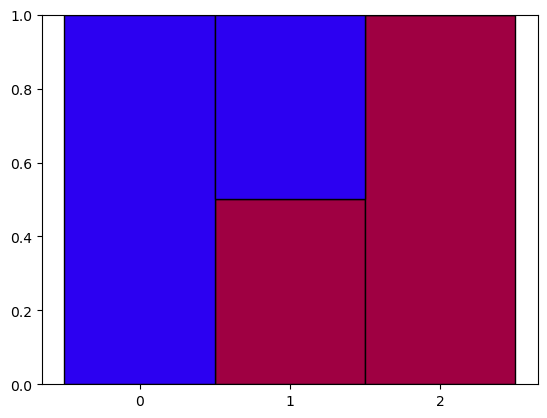

In [6]:
def plot_stacked_barplot(data, x_var, order, palette=None, ax=None, **kwargs):
    if ax is None:
        ax = plt.subplot()
    if palette is None:
        palette = lib.plot.construct_ordered_palette(order)

    # Bar styles
    bar_kwargs = dict(
        width=1.0,
        alpha=1.0,
        edgecolor="k",
        lw=1,
    )
    bar_kwargs.update(kwargs)

    # Plot each bar segment
    _last_top = 0
    for y_var in order:
        ax.bar(
            x=data[x_var],
            height=data[y_var],
            bottom=_last_top,
            label=y_var,
            color=palette[y_var],
            **bar_kwargs,
        )
        _last_top += data[y_var]
    ax.set_xticks(data[x_var].values)
    return ax


def rename_timepoints_for_ts(old_tp_label):
    if isinstance(old_tp_label, float):
        if np.isnan(old_tp_label):
            return ""
        else:
            assert False, "No idea what's going on here."
    if old_tp_label == "E0":
        return "pE"
    elif old_tp_label.startswith("E"):
        return old_tp_label.replace("E0", "EE")
    elif old_tp_label.startswith("Po0"):
        return old_tp_label.replace("Po0", "PE")
    elif old_tp_label.startswith("Po"):
        return old_tp_label.replace("Po", "PE")


plot_stacked_barplot(
    pd.DataFrame(dict(t=[0, 1, 2], y1=[0.0, 0.5, 1.0], y2=[1.0, 0.5, 0.0])),
    x_var="t",
    order=["y1", "y2"],
)

In [7]:
sns.set_context("paper")
plt.rcParams["figure.dpi"] = 100

# Prepare Data

## Load Metadata

In [8]:
pair_type_palette = {
    "EEN:PostEEN": "tab:green",
    "EEN": "tab:blue",
    "PostEEN": "tab:orange",
}

diet_palette = {
    "EEN": "lightgreen",
    "PostEEN": "lightblue",
    "InVitro": "plum",
    "PreEEN": "lightpink",
}

subject_order = [
    "A",
    "B",
    "H",
    "C",
    "D",
    "E",
    "F",
    "G",
    "K",
    "L",
    "M",
    "N",
    "O",
    "P",
    "Q",
    "R",
    "S",
    "T",
    "U",
]

# NOTE: Requires a dummy value because I want exactly 20 items.
subject_palette = lib.plot.construct_ordered_palette(
    subject_order + [f"dummy{i}" for i in range(20 - len(subject_order))], cm="tab20"
)
subject_palette["X"] = "black"
pair_type_order = ["EEN", "EEN:PostEEN", "PostEEN"]
pair_type_marker_palette = {"EEN": "s", "EEN:PostEEN": ">", "PostEEN": "o"}
pair_type_linestyle_palette = {"EEN": ":", "EEN:PostEEN": "-.", "PostEEN": "-"}

In [9]:
# List of all species with pangenome profiles

species_list = pd.read_table("meta/species_group.tsv", dtype=str)[
    lambda x: x.species_group_id == "een"
].species_id
assert species_list.is_unique
species_list = list(species_list)

In [10]:
sample = (
    pd.read_table("meta/een-mgen/sample.tsv")
    .assign(
        label=lambda x: x[
            ["collection_date_relative_een_end", "diet_or_media", "sample_id"]
        ].apply(tuple, axis=1)
    )
    .set_index("sample_id")
)
subject = pd.read_table("meta/een-mgen/subject.tsv", index_col="subject_id")

In [11]:
# Taxonomy embedded in the counts table file.
rotu_counts0 = pd.read_table(
    "data/group/een/a.proc.zotu_counts.tsv", index_col="#OTU ID"
).rename_axis(index="zotu", columns="sample_id")

rotu_taxonomy0 = rotu_counts0.taxonomy
rotu_taxonomy = rotu_taxonomy0.str.split(";").apply(
    lambda x: pd.Series(x, index=["d__", "p__", "c__", "o__", "f__", "g__", "s__"])
)

In [12]:
motu_taxonomy_inpath = "ref/uhgg_genomes_all_v2.tsv"

_motu_taxonomy = (
    pd.read_table(motu_taxonomy_inpath)[lambda x: x.Genome == x.Species_rep]
    .assign(species_id=lambda x: "1" + x.MGnify_accession.str.split("-").str[2])
    .set_index("species_id")
)

motu_lineage_string = _motu_taxonomy.Lineage


def _parse_taxonomy_string(taxonomy_string):
    values = taxonomy_string.split(";")
    return pd.Series(values, index=["d__", "p__", "c__", "o__", "f__", "g__", "s__"])


motu_taxonomy = _motu_taxonomy.Lineage.apply(
    _parse_taxonomy_string
)  # .assign(taxonomy_string=motu_lineage_string)
motu_taxonomy

/tmp/bsmith/ipykernel_1190136/1582564101.py:4: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_table(motu_taxonomy_inpath)[lambda x: x.Genome == x.Species_rep]


,d__,p__,c__,o__,f__,g__,s__
species_id,,,,,,,
100001,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Peptostreptococcales,f__Peptostreptococcaceae,g__GCA-900066495,s__
100002,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Lachnospirales,f__Lachnospiraceae,g__Blautia_A,s__Blautia_A sp900066165
100003,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__Rikenellaceae,g__Alistipes,s__Alistipes shahii
100004,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Oscillospirales,f__Ruminococcaceae,g__Anaerotruncus,s__Anaerotruncus colihominis
100005,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Peptostreptococcales,f__Peptostreptococcaceae,g__Terrisporobacter,s__Terrisporobacter glycolicus_A
...,...,...,...,...,...,...,...
104640,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__Bacteroidaceae,g__Prevotella,s__
104641,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Burkholderiales,f__Burkholderiaceae,g__Sutterella,s__
104642,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Lachnospirales,f__,g__,s__


In [13]:
cog_meta = pd.read_table(
    "ref/cog-20.meta.tsv",
    encoding="latin10",
    names=["cog", "categories", "description", "gene_name", "pathway", "_5", "color"],
    index_col="cog",
)
cog_meta

,categories,description,gene_name,pathway,_5,color
cog,,,,,,
COG0001,H,Glutamate-1-semialdehyde aminotransferase,HemL,Heme biosynthesis,NaN,2CFB
COG0002,E,N-acetyl-gamma-glutamylphosphate reductase,ArgC,Arginine biosynthesis,NaN,3DR3
COG0003,P,"Anion-transporting ATPase, ArsA/GET3 family",ArsA,NaN,NaN,1F48
COG0004,P,Ammonia channel protein AmtB,AmtB,NaN,NaN,1U77
COG0005,F,Purine nucleoside phosphorylase,XapA,Purine salvage,NaN,1YQQ
...,...,...,...,...,...,...
COG5946,V,CRISPR-Cas system type I-G effector complex su...,Csb5gr5,CRISPR-Cas system,NaN,NaN
COG5947,V,CRISPR-Cas system type I-D effector complex su...,Csc1gr5,CRISPR-Cas system,NaN,NaN
COG5948,V,CRISPR-Cas system type I-D effector complex su...,Csc2gr7,CRISPR-Cas system,NaN,NaN


In [14]:
cog_category_meta = pd.read_table(
    "ref/cog-20.categories.tsv",
    names=["category", "color", "description"],
    index_col="category",
)
cog_category_meta

,color,description
category,,
J,FCCCFC,"Translation, ribosomal structure and biogenesis"
A,FCDCFC,RNA processing and modification
K,FCDCEC,Transcription
L,FCDCDC,"Replication, recombination and repair"
B,FCDCCC,Chromatin structure and dynamics
D,FCFCDC,"Cell cycle control, cell division, chromosome ..."
Y,FCFCCC,Nuclear structure
V,FCFCBC,Defense mechanisms
T,FCFCAC,Signal transduction mechanisms


In [15]:
# Ubiquitous, single-copy genes to be used for estimating total genome depth:

schg_cog_list = [
    "COG0012",
    "COG0016",
    "COG0048",
    "COG0049",
    "COG0052",
    "COG0080",
    "COG0081",
    "COG0085",
    "COG0087",
    "COG0088",
    "COG0090",
    "COG0091",
    "COG0092",
    "COG0093",
    "COG0094",
    "COG0096",
    "COG0097",
    "COG0098",
    "COG0099",
    "COG0100",
    "COG0102",
    "COG0103",
    "COG0124",
    "COG0184",
    "COG0185",
    "COG0186",
    "COG0197",
    "COG0200",
    "COG0201",
    "COG0256",
    "COG0495",
    "COG0522",
    "COG0525",
    "COG0533",
    "COG0542",  # This one is a depth outlier...
]

cog_meta.loc[schg_cog_list]

,categories,description,gene_name,pathway,_5,color
cog,,,,,,
COG0012,J,"Ribosome-binding ATPase YchF, GTP1/OBG family",GTP1,NaN,21527254,2DWQ
COG0016,J,Phenylalanyl-tRNA synthetase alpha subunit,PheS,Aminoacyl-tRNA synthetases,NaN,3L4G
COG0048,J,Ribosomal protein S12,RpsL,Ribosome 30S subunit,NaN,4V4H
COG0049,J,Ribosomal protein S7,RpsG,Ribosome 30S subunit,NaN,4V4H
COG0052,J,Ribosomal protein S2,RpsB,Ribosome 30S subunit,NaN,4V4H
COG0080,J,Ribosomal protein L11,RplK,Ribosome 50S subunit,NaN,2E34
COG0081,J,Ribosomal protein L1,RplA,Ribosome 50S subunit,NaN,3J65
COG0085,K,"DNA-directed RNA polymerase, beta subunit/140 ...",RpoB,RNA polymerase,NaN,5UAJ
COG0087,J,Ribosomal protein L3,RplC,Ribosome 50S subunit,NaN,1VS6


## Load Data

### zOTUs

In [16]:
rotu_counts = pd.read_table(
    "data/group/een/a.proc.zotu_counts.tsv", index_col="#OTU ID"
).rename_axis(index="zotu", columns="sample_id")
rotu_counts = rotu_counts.drop(columns=["taxonomy"]).T
rotu_rabund = rotu_counts.divide(rotu_counts.sum(1), axis=0)

sample_rotu_bc_cdmat = sp.spatial.distance.pdist(rotu_rabund, "braycurtis")
sample_rotu_bc_pdist = pd.DataFrame(
    squareform(sample_rotu_bc_cdmat), index=rotu_rabund.index, columns=rotu_rabund.index
)
sample_rotu_bc_linkage = sp.cluster.hierarchy.linkage(
    sample_rotu_bc_cdmat, method="average", optimal_ordering=True
)

rotu_rabund

zotu,Zotu159,Zotu93,Zotu51,Zotu10,Zotu3,Zotu18,Zotu48,Zotu5,Zotu131,Zotu153,...,Zotu1792,Zotu1831,Zotu1857,Zotu455,Zotu1358,Zotu1012,Zotu1127,Zotu1356,Zotu1173,Zotu1591
sample_id,,,,,,,,,,,,,,,,,,,,,
CF_375,0.049365,0.035212,0.079291,0.047063,0.178830,0.186418,0.058786,0.059766,0.017052,0.016114,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CF_253,0.000000,0.000000,0.000000,0.000000,0.166229,0.000000,0.000000,0.001034,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CF_177,0.000000,0.000067,0.000034,0.218621,0.000067,0.000336,0.000000,0.128435,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CF_376,0.000084,0.017133,0.000084,0.038980,0.085326,0.101574,0.054639,0.057122,0.018143,0.018227,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CF_254,0.000000,0.000000,0.000000,0.000223,0.230809,0.000000,0.000000,0.000372,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CF_429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.239417,0.045634,0.038541,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CF_430,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.228835,0.041594,0.036354,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CF_431,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.225448,0.050592,0.045357,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Species

In [17]:
motu_depth = (
    pd.read_table(
        "data/group/een/r.proc.gene99_v20-v23-agg75.spgc_specgene-ref-filt-p95.all_species_depth.tsv",
        index_col=["sample", "species_id"],
    )
    .depth.unstack(fill_value=0)
    .rename(columns=str, index=lambda x: "CF_" + str(int(x.split("_")[1])))
    .rename({"CF_15": "CF_11", "CF_11": "CF_15"})
)
motu_rabund = motu_depth.divide(motu_depth.sum(1), axis=0)

sample_motu_bc_cdmat = sp.spatial.distance.pdist(motu_rabund, "braycurtis")
sample_motu_bc_pdist = pd.DataFrame(
    squareform(sample_motu_bc_cdmat), index=motu_rabund.index, columns=motu_rabund.index
)
sample_motu_bc_linkage = sp.cluster.hierarchy.linkage(
    sample_motu_bc_cdmat, method="average", optimal_ordering=True
)

motu_rabund

species_id,100003,100013,100014,100016,100022,100028,100029,100032,100033,100035,...,104341,104345,104404,104431,104468,104491,104501,104526,104639,104644
sample,,,,,,,,,,,,,,,,,,,,,
CF_2,2.302034e-08,0.000085,0.0,0.000000,0.000003,0.000000,0.002197,0.006052,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0
CF_3,0.000000e+00,0.000200,0.0,0.000000,0.000195,0.000136,0.002408,0.002536,0.000000,0.0,...,0.0,0.001219,0.000000,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0
CF_4,0.000000e+00,0.000081,0.0,0.000000,0.000021,0.000000,0.005202,0.005238,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0
CF_5,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000319,0.000000,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0
CF_6,7.947844e-03,0.000006,0.0,0.000001,0.000661,0.000226,0.000146,0.000286,0.008499,0.0,...,0.0,0.000236,0.000000,0.0,0.0,0.0,0.0,3.330041e-07,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CF_95,6.755695e-03,0.001454,0.0,0.000000,0.001353,0.000000,0.001182,0.000180,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,5.200820e-04,0.0,0.0
CF_96,1.096530e-02,0.002603,0.0,0.000000,0.002544,0.000090,0.001361,0.001032,0.000000,0.0,...,0.0,0.001246,0.000000,0.0,0.0,0.0,0.0,6.739957e-03,0.0,0.0
CF_97,7.025583e-03,0.001686,0.0,0.000000,0.000000,0.000000,0.002139,0.000005,0.000000,0.0,...,0.0,0.000000,0.000918,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0


In [18]:
motu_rabund_thresh = 1e-4
motu_prevalence_by_subject = (
    motu_rabund.gt(motu_rabund_thresh)
    .groupby(sample[lambda x: x.sample_type == "human"].subject_id)
    .mean()
)

### Strains

/tmp/bsmith/ipykernel_1190136/2318261322.py:32: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  sample_sotu_bc_linkage = sp.cluster.hierarchy.linkage(


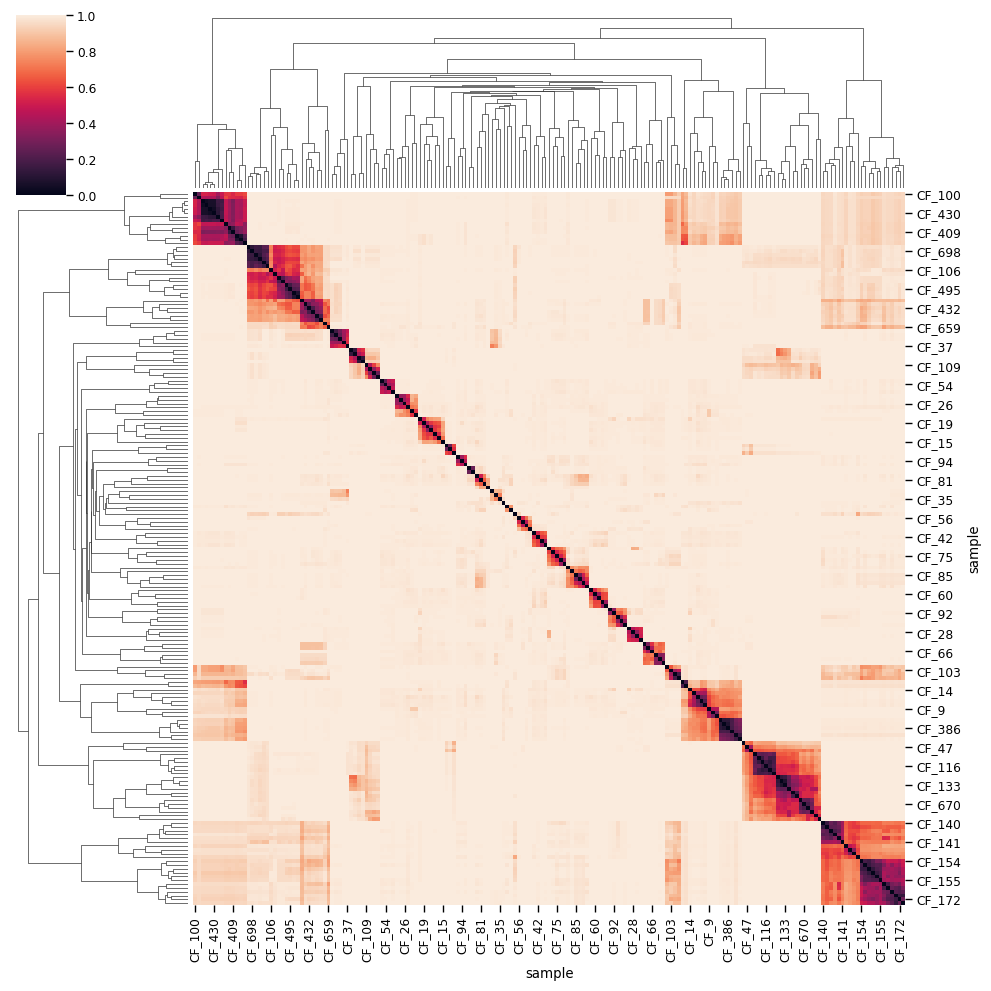

In [19]:
sotu_depth = []
missing_files = []
for species_id in motu_depth.columns:
    path = f"data/group/een/species/sp-{species_id}/r.proc.gtpro.sfacts-fit.comm.tsv"
    try:
        d = (
            pd.read_table(path, index_col=["sample", "strain"])
            .squeeze()
            .unstack()
            .rename(columns=str, index=lambda x: "CF_" + str(int(x.split("_")[1])))
            .rename({"CF_11": "CF_15", "CF_15": "CF_11"})  # Sample swap.
        )
    except FileNotFoundError:
        missing_files.append(path)
        d = pd.DataFrame([])
    _keep_strains = idxwhere(d.sum() > 0.05)
    assert d.index.isin(motu_depth.index).all()
    d = d.reindex(index=motu_depth.index, columns=_keep_strains, fill_value=0)
    d = d.assign(__other=lambda x: 1 - x.sum(1)).rename(columns={"__other": -1})
    d[d < 0] = 0
    d = d.divide(d.sum(1), axis=0)
    d = d.multiply(motu_depth[species_id], axis=0)
    d = d.rename(columns=lambda s: f"{species_id}_{s}")
    sotu_depth.append(d)
sotu_depth = pd.concat(sotu_depth, axis=1)
sotu_rabund = sotu_depth.divide(sotu_depth.sum(1), axis=0)

sample_sotu_bc_cdmat = sp.spatial.distance.pdist(sotu_rabund, metric="braycurtis")
sample_sotu_bc_pdist = pd.DataFrame(
    squareform(sample_sotu_bc_cdmat), index=sotu_rabund.index, columns=sotu_rabund.index
)
sample_sotu_bc_linkage = sp.cluster.hierarchy.linkage(
    sample_sotu_bc_pdist, method="average", optimal_ordering=True
)

sns.clustermap(
    sample_sotu_bc_pdist,
    col_linkage=sample_sotu_bc_linkage,
    row_linkage=sample_sotu_bc_linkage,
)

### Genes

In [20]:
# Load table of gene depths for each species and aggregate by COG.
# Can take up to 8 minutes to compile everything
cog_depth = {}

for species in tqdm(species_list):
    gene_x_cog_inpath = (
        f"data/species/sp-{species}/midasdb_v20.emapper.gene75_x_cog.tsv"
    )
    gene_depth_inpath = (
        f"data/group/een/species/sp-{species}/r.proc.gene99_v20-v23-agg75.depth2.nc"
    )
    _gene_x_cog = (
        pd.read_table(gene_x_cog_inpath)
        .drop_duplicates()
        .set_index("centroid_75")
        .squeeze()
    )

    # Calculate the depth of each COG by summing all genes labeled as that COG.
    _cog_depth = (
        xr.load_dataarray(gene_depth_inpath)
        .to_pandas()
        .T.join(_gene_x_cog)
        .groupby("cog")
        .sum()
    )
    cog_depth[species] = _cog_depth.stack()

cog_depth = (
    pd.DataFrame(cog_depth)
    .stack()
    .rename_axis(["cog", "sample", "species"])
    .to_xarray()
    .fillna(0)
)

# Normalize sample names and swap the mislabeled samples.
cog_depth["sample"] = (
    cog_depth.sample.to_series()
    .map(lambda x: "CF_" + str(int(x.split("_")[1])))
    .replace({"CF_15": "CF_11", "CF_11": "CF_15"})
    .values
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 369/369 [01:07<00:00,  5.46it/s]


# Analyses

## Species Enrichment

In [21]:
def enrichment_test(d):
    try:
        res = sp.stats.wilcoxon(d["PostEEN"], d["EEN"])
    except ValueError:
        res = (np.nan, np.nan)
    log2_ratio = np.log2(d["PostEEN"] / d["EEN"])
    return pd.Series(
        [log2_ratio.mean(), d["EEN"].mean(), d["PostEEN"].mean(), res[1]],
        index=["log2_ratio", "mean_EEN", "mean_PostEEN", "pvalue"],
    )

In [22]:
motu_enrichment_results = (
    motu_rabund.apply(lambda x: x + x.replace({0: np.inf}).min())
    .join(sample[["subject_id", "diet_or_media"]])
    .groupby(["subject_id", "diet_or_media"])
    .mean()
    .stack()
    .unstack("diet_or_media")[["EEN", "PostEEN"]]
    .dropna()
    # .assign(log2_ratio=lambda x: np.log2(x["EEN"] / x["PostEEN"]))
    .rename_axis(index=["subject_id", "motu_id"])
    .groupby(level="motu_id")
    .apply(enrichment_test)
)

/pollard/home/bsmith/.snakemake/conda/8dd43b17b83f3accb639079fe0075b14_/lib/python3.10/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/pollard/home/bsmith/.snakemake/conda/8dd43b17b83f3accb639079fe0075b14_/lib/python3.10/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [23]:
motu_enrichment_results_with_fdr = (
    motu_enrichment_results.dropna(subset=["pvalue"])[
        lambda x: (x.mean_EEN > 1e-3) | (x.mean_PostEEN > 1e-3)
    ]
    .assign(
        fdr=lambda x: fdrcorrection(x.pvalue)[1],
        hit=lambda x: (True & (x.fdr < 0.1)),
    )
    .sort_values("fdr")
)
motu_enrichment_results_with_fdr.sort_values("pvalue")

,log2_ratio,mean_EEN,mean_PostEEN,pvalue,fdr,hit
motu_id,,,,,,
102544,-1.446061,0.006958,0.001896,0.000763,0.037396,True
103683,5.261952,0.000100,0.002064,0.000982,0.037396,True
103694,9.161396,0.000510,0.012049,0.000982,0.037396,True
100185,4.082775,0.000743,0.002353,0.000987,0.037396,True
104158,10.741116,0.001901,0.013699,0.001204,0.037396,True
...,...,...,...,...,...,...
101349,1.090560,0.007116,0.003172,0.954708,0.975690,False
100278,-0.180896,0.000946,0.001169,1.000000,1.000000,False
102322,-0.651913,0.019062,0.000011,1.000000,1.000000,False


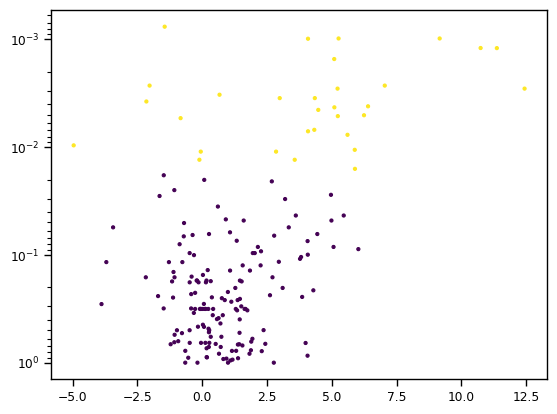

In [24]:
fig, ax = plt.subplots()
ax.scatter("log2_ratio", "pvalue", c="hit", data=motu_enrichment_results_with_fdr, s=5)
ax.set_yscale("log")
ax.yaxis.set_inverted(True)

In [25]:
motu_enrichment_results_with_fdr.loc["101493"]

log2_ratio     -1.481352
mean_EEN        0.021717
mean_PostEEN    0.006953
pvalue           0.01825
fdr             0.106075
hit                False
Name: 101493, dtype: object

(array([345.,  14.,   6.,   1.,   0.,   2.,   0.,   0.,   0.,   1.]),
 array([9.73037068e-07, 9.55350605e-03, 1.91060391e-02, 2.86585721e-02,
        3.82111051e-02, 4.77636381e-02, 5.73161711e-02, 6.68687041e-02,
        7.64212371e-02, 8.59737702e-02, 9.55263032e-02]),
 <BarContainer object of 10 artists>)

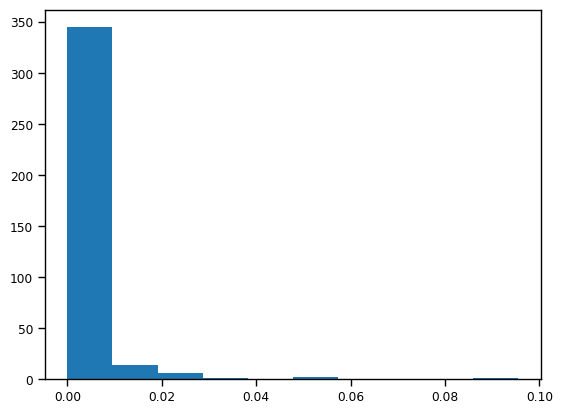

In [26]:
motu_mean_rabund = (
    motu_enrichment_results.mean_EEN + motu_enrichment_results.mean_PostEEN
) / 2
plt.hist(motu_mean_rabund)

## COG Enrichment

### Detection Limit Imputation

In [27]:
cog_detection_limit = cog_depth.where(lambda x: x != 0, np.inf).min(
    ("sample", "species")
)
undetected_cogs_list = idxwhere((cog_detection_limit == np.inf).to_series())

cog_depth_or_detection_limit = cog_depth.where(
    lambda x: x != 0, cog_detection_limit
).drop_sel(cog=undetected_cogs_list)

cog_depth_or_detection_limit

<xarray.DataArray (cog: 4291, sample: 187, species: 369)>
array([[[7.30994152e-04, 7.30994152e-04, 7.30994152e-04, ...,
         7.30994152e-04, 7.30994152e-04, 7.30994152e-04],
        [7.30994152e-04, 7.30994152e-04, 7.30994152e-04, ...,
         7.30994152e-04, 7.30994152e-04, 7.30994152e-04],
        [7.30994152e-04, 7.30994152e-04, 7.30994152e-04, ...,
         7.30994152e-04, 7.30994152e-04, 7.30994152e-04],
        ...,
        [7.30994152e-04, 7.30994152e-04, 7.30994152e-04, ...,
         7.30994152e-04, 7.30994152e-04, 7.30994152e-04],
        [7.30994152e-04, 7.30994152e-04, 7.30994152e-04, ...,
         7.30994152e-04, 7.30994152e-04, 7.30994152e-04],
        [7.30994152e-04, 7.30994152e-04, 7.30994152e-04, ...,
         7.30994152e-04, 7.30994152e-04, 7.30994152e-04]],

       [[9.31098696e-04, 2.31166151e-01, 9.31098696e-04, ...,
         9.31098696e-04, 9.31098696e-04, 9.31098696e-04],
        [9.31098696e-04, 7.46542828e+00, 9.31098696e-04, ...,
         9.31098696e-04, 9.31098696e-04, 9.31098696e-04],
        [9.31098696e-04, 9.31098696e-04, 9.31098696e-04, ...,
         9.31098696e-04, 9.31098696e-04, 9.31098696e-04],
...
        [7.75193798e-04, 7.75193798e-04, 7.75193798e-04, ...,
         7.75193798e-04, 7.75193798e-04, 7.75193798e-04],
        [7.75193798e-04, 7.75193798e-04, 7.75193798e-04, ...,
         7.75193798e-04, 7.75193798e-04, 7.75193798e-04],
        [4.39696970e+00, 7.75193798e-04, 7.75193798e-04, ...,
         7.75193798e-04, 7.75193798e-04, 7.75193798e-04]],

       [[1.62601626e-03, 1.62601626e-03, 1.62601626e-03, ...,
         1.62601626e-03, 1.62601626e-03, 1.62601626e-03],
        [1.62601626e-03, 1.62601626e-03, 1.62601626e-03, ...,
         1.62601626e-03, 1.62601626e-03, 1.62601626e-03],
        [1.62601626e-03, 1.62601626e-03, 1.62601626e-03, ...,
         1.62601626e-03, 1.62601626e-03, 1.62601626e-03],
        ...,
        [1.62601626e-03, 1.62601626e-03, 1.62601626e-03, ...,
         1.62601626e-03, 1.62601626e-03, 1.62601626e-03],
        [1.62601626e-03, 1.62601626e-03, 1.62601626e-03, ...,
         1.62601626e-03, 1.62601626e-03, 1.62601626e-03],
        [1.62601626e-03, 1.62601626e-03, 1.62601626e-03, ...,
         1.62601626e-03, 1.62601626e-03, 1.62601626e-03]]])
Coordinates:
  * cog      (cog) object 'COG0001' 'COG0002' 'COG0003' ... 'COG5662' 'COG5663'
  * species  (species) object '100003' '100013' '100014' ... '104639' '104644'
  * sample   (sample) object 'CF_2' 'CF_3' 'CF_4' ... 'CF_701' 'CF_702' 'CF_659'

### Normalize COG depth

In [28]:
total_genome_depth = (
    cog_depth_or_detection_limit.sel(cog=schg_cog_list)
    .median("cog")
    .sum("species")  # NOTE: Mean or Median? Does it matter?
)
normalized_cog_depth_by_sample = (
    cog_depth_or_detection_limit.sum("species") / total_genome_depth
)

### Aggregate by Subject

In [29]:
normalized_cog_depth_by_subject_and_type = (
    normalized_cog_depth_by_sample.to_pandas()
    .T.join(sample[["subject_id", "diet_or_media"]])[
        lambda x: x.diet_or_media.isin(["EEN", "PostEEN"])
    ]
    .groupby(["subject_id", "diet_or_media"])
    .median()  # NOTE: Mean or Median?
    .unstack("diet_or_media")
    .dropna()
    .stack("diet_or_media")
)
normalized_cog_depth_by_subject_and_type

COG0001   COG0002   COG0003   COG0004   COG0005  \
subject_id diet_or_media                                                     
A          EEN            0.435578  1.446039  0.340660  1.037106  1.102036   
           PostEEN        0.453258  1.169817  0.134460  0.949484  1.029237   
B          EEN            0.701148  1.090161  0.010364  0.675775  1.021515   
           PostEEN        0.503717  1.204782  0.008562  1.188357  0.937564   
C          EEN            0.279244  1.365074  0.001227  1.445223  1.128507   
           PostEEN        0.222662  1.420612  0.003395  1.125651  1.196588   
D          EEN            0.241344  1.107008  0.083129  1.138839  0.986568   
           PostEEN        0.284242  1.082865  0.062585  0.993375  0.947778   
E          EEN            0.872235  1.805706  0.471120  1.130520  1.121574   
           PostEEN        0.421310  1.445739  0.736259  1.676195  1.368578   
F          EEN            0.605696  1.157004  0.028174  1.178380  1.615134   
           PostEEN        0.446659  1.519789  0.033599  1.349375  1.237947   
G          EEN            0.196049  1.263738  0.205267  1.212437  1.021296   
           PostEEN        0.370432  1.311607  0.149710  1.308936  1.046550   
H          EEN            0.593872  1.071025  0.001583  1.296466  1.398258   
           PostEEN        0.252250  1.548020  0.004624  1.968300  1.067047   
K          EEN            0.290374  1.307250  0.266637  1.355196  1.395507   
           PostEEN        0.154624  1.301400  0.215681  1.366275  1.172227   
L          EEN            0.317561  1.224330  0.186730  1.412244  1.148408   
           PostEEN        0.250740  1.294988  0.182769  1.435332  0.938470   
M          EEN            0.412082  0.999450  0.080567  0.676189  0.864096   
           PostEEN        0.358456  1.104263  0.119699  0.933462  0.733447   
N          EEN            0.297904  1.364714  0.223288  0.851242  1.140337   
           PostEEN        0.301914  1.250344  0.133834  1.293578  0.940582   
Q          EEN            0.415821  1.065096  0.158288  0.957929  1.046431   
           PostEEN        0.337060  1.159106  0.367105  1.218968  1.172717   
R          EEN            0.897610  1.367385  0.019486  0.765139  1.205727   
           PostEEN        0.285614  1.395773  0.056338  1.112091  1.032187   
S          EEN            0.409403  1.101807  0.372415  0.846772  1.257231   
           PostEEN        0.353739  1.253747  0.255478  1.175161  1.043397   
T          EEN            0.348194  1.096281  0.060693  0.962219  1.079281   
           PostEEN        0.310347  1.204379  0.037772  1.187780  0.970343   

                           COG0006   COG0007   COG0008   COG0009   COG0010  \
subject_id diet_or_media                                                     
A          EEN            3.152614  0.561151  3.336849  1.893504  1.194150   
           PostEEN        3.125007  0.496238  3.167467  1.936249  1.042774   
B          EEN            2.474938  0.532203  3.084160  1.658687  0.984518   
           PostEEN        2.737762  0.280960  3.098715  1.692325  1.241627   
C          EEN            2.727230  0.316947  3.231560  1.619063  0.950894   
           PostEEN        3.331012  0.387808  3.310174  1.863158  1.165790   
D          EEN            2.763736  0.258506  2.920314  1.774188  0.506198   
           PostEEN        2.476455  0.369844  2.827239  1.632464  0.610735   
E          EEN            3.987506  0.754356  3.633381  2.210192  1.420298   
           PostEEN        3.201130  0.663528  3.948284  2.180805  0.644478   
F          EEN            6.195424  1.135256  2.972941  1.708359  1.561099   
           PostEEN        3.820087  0.686596  3.278024  2.192458  1.076334   
G          EEN            3.695436  0.271582  2.872228  1.860790  1.153783   
           PostEEN        2.899328  0.331058  3.038952  1.654322  0.892893   
H          EEN            4.860809  1.431903  3.285211  1.395752  1.370657   
           PostEEN        2.225471  0.253961  2.

### Perform Tests

In [30]:
pairwise_cog_test_results = {}
for cog in tqdm(normalized_cog_depth_by_subject_and_type.columns):
    d = normalized_cog_depth_by_subject_and_type[cog].unstack()
    mean_een = d.EEN.mean()
    mean_post = d.PostEEN.mean()
    mean_log2_ratio = np.log2(d.PostEEN / d.EEN).mean()
    median_log2_ratio = np.log2(d.PostEEN / d.EEN).median()
    try:
        result = sp.stats.wilcoxon(
            d.PostEEN,
            d.EEN,
        )
        pval = result.pvalue
    except ValueError:
        pval = np.nan
    pairwise_cog_test_results[cog] = (
        mean_een,
        mean_post,
        mean_log2_ratio,
        median_log2_ratio,
        pval,
    )

pairwise_cog_test_results = pd.DataFrame(
    pairwise_cog_test_results,
    index=("mean_een", "mean_post", "mean_log2_ratio", "median_log2_ratio", "pval"),
).T

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4291/4291 [00:05<00:00, 765.52it/s]


### Calculate FDR

In [31]:
# Here is where I define filters on COGs:
#    ~~They must have a mean depth during one of the two time-periods of > 0.01~~

pairwise_cog_test_results_filt_with_fdr = (
    pairwise_cog_test_results.dropna(subset=["pval"])[
        lambda x: (x.mean_een > 0.01) | (x.mean_post > 0.01)
    ]
    .assign(
        fdr=lambda x: fdrcorrection(x.pval)[1],
        hit=lambda x: (
            True
            & (x.fdr < 0.1)
            # & (np.abs(x.mean_log2_ratio) > 0.2)
        ),
    )
    .sort_values("fdr")
)
pairwise_cog_test_results_filt_with_fdr.sort_values("pval")

,mean_een,mean_post,mean_log2_ratio,median_log2_ratio,pval,fdr,hit
COG3964,0.170636,0.043335,-1.798413,-1.600867,0.000061,0.027139,True
COG5599,0.003933,0.026654,3.391656,4.120756,0.000061,0.027139,True
COG1082,6.852694,5.194296,-0.391602,-0.235647,0.000061,0.027139,True
COG3302,0.235295,0.086583,-1.210468,-0.866961,0.000092,0.027139,True
COG0673,10.284605,7.901581,-0.359273,-0.183122,0.000092,0.027139,True
...,...,...,...,...,...,...,...
COG0705,2.732881,2.710378,-0.012785,-0.013868,1.000000,1.000000,False
COG0151,1.870500,1.842663,-0.017810,0.002697,1.000000,1.000000,False
COG0535,2.883306,2.886212,-0.000488,0.047996,1.000000,1.000000,False
COG0534,21.668503,20.756027,-0.054797,0.028934,1.000000,1.000000,False


In [32]:
pairwise_cog_test_results_filt_with_fdr[
    lambda x: (x.median_log2_ratio < 0) & x.hit
].shape

(529, 7)

In [33]:
pairwise_cog_test_results_filt_with_fdr[
    lambda x: (x.median_log2_ratio > 0) & x.hit
].shape

(54, 7)

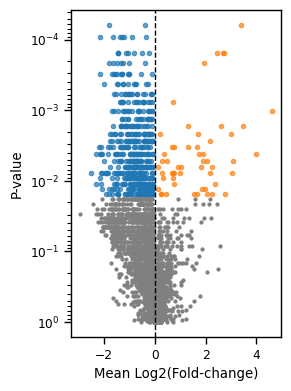

In [34]:
d = pairwise_cog_test_results_filt_with_fdr.sort_values("pval").join(cog_meta)

fig, ax = plt.subplots(figsize=(3, 4))
ax.scatter(
    "mean_log2_ratio",
    "pval",
    data=d[d.hit & (d.mean_log2_ratio < 0)],
    color="tab:blue",
    s=10,
    alpha=0.7,
)
ax.scatter(
    "mean_log2_ratio",
    "pval",
    data=d[d.hit & (d.mean_log2_ratio > 0)],
    color="tab:orange",
    s=10,
    alpha=0.7,
)
ax.scatter("mean_log2_ratio", "pval", data=d[~d.hit], color="grey", s=5)
ax.invert_yaxis()
ax.set_yscale("log")
ax.axvline(0.0, color="black", lw=1, linestyle="--")
# ax.axvline(-0.2, color="black", lw=1, linestyle="--")
# ax.axhline(0.05, color="black", lw=1, linestyle="--")
ax.set_xlabel("Mean Log2(Fold-change)")
ax.set_ylabel("P-value")
fig.tight_layout()

fig.savefig("fig/een_gene_abundance_test.tall.pdf", bbox_inches="tight")

In [35]:
pairwise_cog_test_results_filt_with_fdr.loc[
    ["COG3845", "COG4603", "COG4813", "COG3867"]
]

,mean_een,mean_post,mean_log2_ratio,median_log2_ratio,pval,fdr,hit
COG3845,1.360215,0.824314,-0.584457,-0.451322,0.010986,0.082068,True
COG4603,1.078703,0.672535,-0.577959,-0.562189,0.010986,0.082068,True
COG4813,0.019640,0.038832,2.060615,2.549080,0.015503,0.099320,True
COG3867,0.427483,0.771500,1.046616,1.392800,0.006287,0.063806,True


## Turnover Analysis

In [36]:
def pair_classifier(sample_typeA, sample_typeB):
    return ":".join(sorted(set([sample_typeA, sample_typeB])))


def construct_turnover_analysis_data(
    dmat,
    meta,
    sample_type_var,
    stratum_var=None,
    time_var=None,
):
    var_list = []
    for var in [sample_type_var, stratum_var, time_var]:
        if var is not None:
            var_list.append(var)
    meta = meta.reindex(dmat.index)[var_list].dropna()
    dmat = dmat.loc[meta.index, meta.index]
    data = []
    for (i, idxA), (j, idxB) in product(enumerate(meta.index), repeat=2):
        pair_data = {
            "sampleA": idxA,
            "sampleB": idxB,
            "sample_typeA": meta.loc[idxA, sample_type_var],
            "sample_typeB": meta.loc[idxB, sample_type_var],
            "diss": dmat.loc[idxA, idxB],
        }
        if stratum_var is not None:
            pair_data.update(
                {
                    "stratumA": meta.loc[idxA, stratum_var],
                    "stratumB": meta.loc[idxB, stratum_var],
                }
            )
        if time_var is not None:
            pair_data.update(
                {"timeA": meta.loc[idxA, time_var], "timeB": meta.loc[idxB, time_var]}
            )
        data.append(pair_data)
    data = pd.DataFrame(
        data,
    )
    data = data.assign(
        pair_type=lambda x: x.apply(
            lambda y: pair_classifier(y.sample_typeA, y.sample_typeB), axis=1
        )
    )

    if time_var:
        data = data.assign(time_delta=lambda x: np.abs(x.timeB - x.timeA))

    data = data[lambda x: (x.stratumA == x.stratumB) & (x.sampleA < x.sampleB)]
    if stratum_var:
        data = data.assign(stratum=lambda x: x.stratumA)

    return data

### All Species (zOTUs)

In [37]:
formula = "diss ~ 0 + pair_type + cr(time_delta, 4) + C(stratum, Sum)"
coef_name_list = ["pair_type[EEN]", "pair_type[PostEEN]", "pair_type[EEN:PostEEN]"]
n_perm = 999

turnover_data = construct_turnover_analysis_data(
    sample_rotu_bc_pdist,
    meta=sample[lambda x: x.diet_or_media.isin(["EEN", "PostEEN"])],
    sample_type_var="diet_or_media",
    stratum_var="subject_id",
    time_var="collection_date_relative_een_end",
)

obs_fit = smf.ols(formula, data=turnover_data).fit()
obs_fit.summary()

global_rotu_obs_coefs = obs_fit.params.reindex(coef_name_list)
global_rotu_obs_coefs["num_pairs"] = obs_fit.nobs
global_rotu_obs_coefs["num_subjects_with_pairs"] = turnover_data.stratum.unique().shape[
    0
]
_transition_pairs = turnover_data[lambda x: x.pair_type == "EEN:PostEEN"]
global_rotu_obs_coefs["num_transition_pairs"] = _transition_pairs.shape[0]
global_rotu_obs_coefs[
    "num_subjects_with_transition_pairs"
] = _transition_pairs.stratum.unique().shape[0]

np.random.seed(0)
_null_coef_dists = []
for _ in tqdm(range(n_perm)):
    perm_fit = smf.ols(
        formula,
        data=turnover_data.assign(
            pair_type=lambda x: x.groupby("stratum").pair_type.sample(frac=1).values
        ),
    ).fit()
    _null_coef_dists.append(perm_fit.params.reindex(coef_name_list))

global_rotu_null_coefs = pd.DataFrame(_null_coef_dists)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:19<00:00, 50.44it/s]


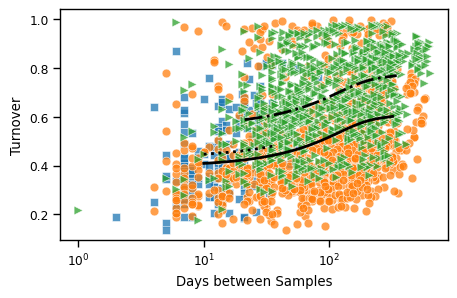

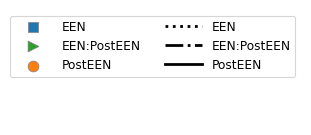

In [38]:
d1 = turnover_data
fit = obs_fit


# pair_type_palette = {'Transition': 'tab:green', 'EEN': 'tab:blue', 'PostEEN': 'tab:orange'}
# pair_type_marker_palette = {'EEN': 's', 'Transition': '>', 'PostEEN': 'o'}
# pair_type_linestyle_palette = {'EEN': ':', 'Transition': '--', 'PostEEN': '-'}

fig, ax = plt.subplots(figsize=(5, 3))
# ax.set_title("Within-subject Pairwise Turnover")
for pair_type in ["EEN", "PostEEN", "EEN:PostEEN"]:
    d3 = d1[lambda x: (x.pair_type == pair_type)]
    ax.scatter(
        "time_delta",
        "diss",
        label="__nolegend__",
        data=d3,
        color=pair_type_palette[pair_type],
        marker=pair_type_marker_palette[pair_type],
        edgecolor="white",
        lw=0.5,
        alpha=0.75,
        s=40,
    )

_arbitrary_subject = d1.stratum.unique()[1]
predict_data = pd.DataFrame(
    product(
        [_arbitrary_subject],
        ["EEN", "PostEEN", "EEN:PostEEN"],
        np.logspace(1.0, 2.6),
    ),
    columns=["stratum", "pair_type", "time_delta"],
)
predict_data = predict_data.assign(
    prediction=fit.predict(predict_data),
    predict_mean_subject=lambda x: x.prediction
    - fit.params[f"C(stratum, Sum)[S.{_arbitrary_subject}]"],
)
for pair_type in pair_type_order:
    d4 = predict_data[lambda x: x.pair_type == pair_type]
    left, right = d1[lambda x: x.pair_type == pair_type].time_delta.quantile(
        [0.05, 0.95]
    )
    ax.plot(
        "time_delta",
        "predict_mean_subject",
        label="__nolegend__",
        data=d4[lambda x: (x.time_delta > left) & (x.time_delta < right)],
        color="black",
        linestyle=pair_type_linestyle_palette[pair_type],
        lw=2,
    )
ax.set_ylabel("Turnover")
ax.set_xlabel("Days between Samples")
ax.set_xscale("symlog", linthresh=1e-1)

fig.savefig("fig/een_turnover_analysis_zotu_level.pdf", bbox_inches="tight")

fig, ax = plt.subplots(figsize=(2.5, 1.5))
for pair_type in pair_type_order:
    ax.scatter(
        [],
        [],
        label=pair_type,
        color=pair_type_palette[pair_type],
        marker=pair_type_marker_palette[pair_type],
        edgecolor="grey",
        lw=0.5,
        s=50,
    )
for pair_type in pair_type_order:
    ax.plot(
        [],
        [],
        label=pair_type,
        color="k",
        linestyle=pair_type_linestyle_palette[pair_type],
        lw=2,
    )
ax.legend(ncols=2, handlelength=3, markerscale=1.1)
lib.plot.hide_axes_and_spines(ax=ax)

fig.savefig("fig/een_turnover_analysis_legend.pdf", bbox_inches="tight")

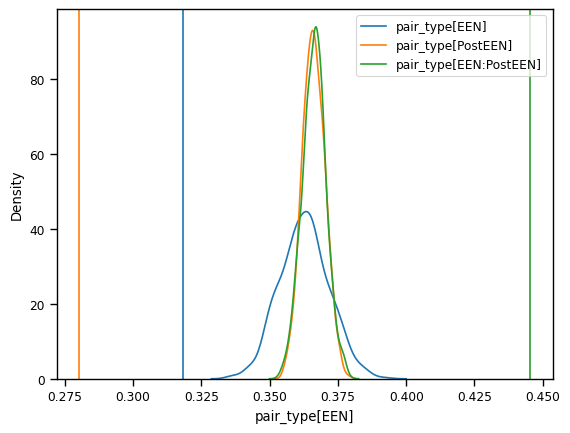

In [39]:
_obs = global_rotu_obs_coefs
_null = global_rotu_null_coefs

for coef, color in zip(coef_name_list, ["tab:blue", "tab:orange", "tab:green"]):
    sns.kdeplot(_null[coef], color=color)
    plt.axvline(_obs[coef], color=color, label=coef)
plt.legend()

0.002
0.002
0.002
0.002


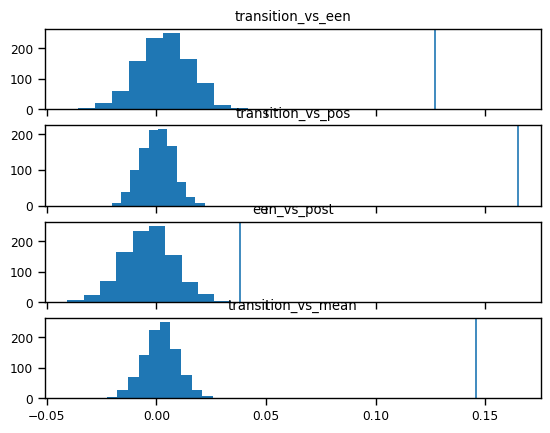

In [40]:
comparisons = dict(
    transition_vs_een=lambda x: x["pair_type[EEN:PostEEN]"] - x["pair_type[EEN]"],
    transition_vs_pos=lambda x: x["pair_type[EEN:PostEEN]"] - x["pair_type[PostEEN]"],
    een_vs_post=lambda x: x["pair_type[EEN]"] - x["pair_type[PostEEN]"],
    transition_vs_mean=lambda x: x["pair_type[EEN:PostEEN]"]
    - 0.5 * (x["pair_type[EEN]"] + x["pair_type[PostEEN]"]),
)

_obs = global_rotu_obs_coefs
_null = global_rotu_null_coefs


fig, axs = plt.subplots(4, sharex=True)
for comp, ax in zip(comparisons, axs):
    x, y = _null.apply(comparisons[comp], axis=1), comparisons[comp](_obs)
    ax.set_title(comp)
    ax.hist(x)
    ax.axvline(y)
    print(calculate_2tailed_pvalue_from_perm(y, x))

In [41]:
calculate_2tailed_pvalue_from_perm

<function __main__.calculate_2tailed_pvalue_from_perm(obs, perms)>

In [42]:
# TODO: Test for the difference between the transition and each of the others

### All Species (Metagenomics)

In [43]:
formula = "diss ~ 0 + pair_type + cr(time_delta, 4) + C(stratum, Sum)"
coef_name_list = ["pair_type[EEN]", "pair_type[PostEEN]", "pair_type[EEN:PostEEN]"]
n_perm = 999

turnover_data = construct_turnover_analysis_data(
    sample_motu_bc_pdist,
    meta=sample[lambda x: x.diet_or_media.isin(["EEN", "PostEEN"])],
    sample_type_var="diet_or_media",
    stratum_var="subject_id",
    time_var="collection_date_relative_een_end",
)

obs_fit = smf.ols(formula, data=turnover_data).fit()
obs_fit.summary()

global_motu_obs_coefs = obs_fit.params.reindex(coef_name_list)
global_motu_obs_coefs["num_pairs"] = obs_fit.nobs
global_motu_obs_coefs["num_subjects_with_pairs"] = turnover_data.stratum.unique().shape[
    0
]
_transition_pairs = turnover_data[lambda x: x.pair_type == "EEN:PostEEN"]
global_motu_obs_coefs["num_transition_pairs"] = _transition_pairs.shape[0]
global_motu_obs_coefs[
    "num_subjects_with_transition_pairs"
] = _transition_pairs.stratum.unique().shape[0]

np.random.seed(0)
_null_coef_dists = []
for _ in tqdm(range(n_perm)):
    perm_fit = smf.ols(
        formula,
        data=turnover_data.assign(
            pair_type=lambda x: x.groupby("stratum").pair_type.sample(frac=1).values
        ),
    ).fit()
    _null_coef_dists.append(perm_fit.params.reindex(coef_name_list))

global_motu_null_coefs = pd.DataFrame(_null_coef_dists)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:07<00:00, 126.61it/s]


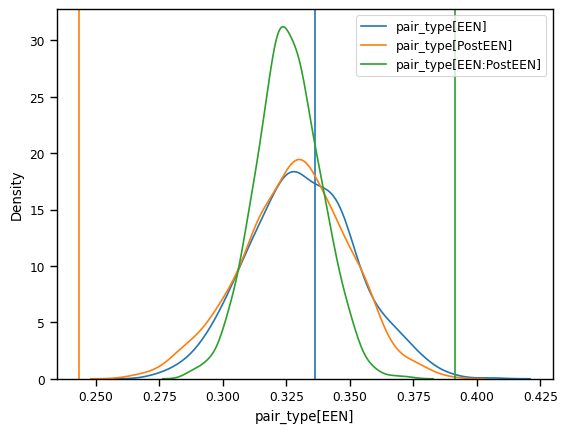

In [44]:
_obs = global_motu_obs_coefs
_null = global_motu_null_coefs

for coef, color in zip(coef_name_list, ["tab:blue", "tab:orange", "tab:green"]):
    sns.kdeplot(_null[coef], color=color)
    plt.axvline(_obs[coef], color=color, label=coef)
plt.legend()

0.034
0.002
0.022
0.002


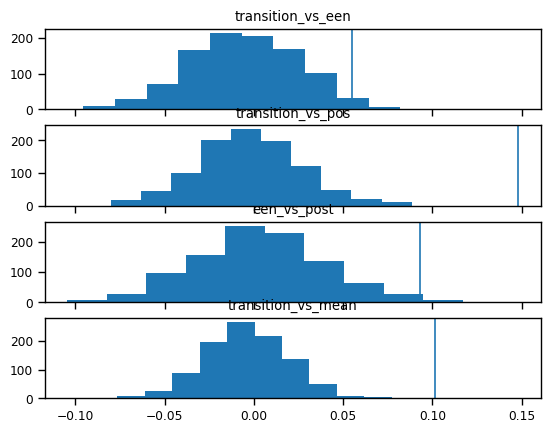

In [45]:
comparisons = dict(
    transition_vs_een=lambda x: x["pair_type[EEN:PostEEN]"] - x["pair_type[EEN]"],
    transition_vs_pos=lambda x: x["pair_type[EEN:PostEEN]"] - x["pair_type[PostEEN]"],
    een_vs_post=lambda x: x["pair_type[EEN]"] - x["pair_type[PostEEN]"],
    transition_vs_mean=lambda x: x["pair_type[EEN:PostEEN]"]
    - 0.5 * (x["pair_type[EEN]"] + x["pair_type[PostEEN]"]),
)

_obs = global_motu_obs_coefs
_null = global_motu_null_coefs


fig, axs = plt.subplots(4, sharex=True)
for comp, ax in zip(comparisons, axs):
    x, y = _null.apply(comparisons[comp], axis=1), comparisons[comp](_obs)
    ax.set_title(comp)
    ax.hist(x)
    ax.axvline(y)
    print(calculate_2tailed_pvalue_from_perm(y, x))

In [46]:
# TODO: Test for the difference between the transition and each of the others

### All Strains

In [47]:
formula = "diss ~ 0 + pair_type + cr(time_delta, 4) + C(stratum, Sum)"
coef_name_list = ["pair_type[EEN]", "pair_type[PostEEN]", "pair_type[EEN:PostEEN]"]
n_perm = 999

turnover_data = construct_turnover_analysis_data(
    sample_sotu_bc_pdist,
    meta=sample[lambda x: x.diet_or_media.isin(["EEN", "PostEEN"])],
    sample_type_var="diet_or_media",
    stratum_var="subject_id",
    time_var="collection_date_relative_een_end",
)

obs_fit = smf.ols(formula, data=turnover_data).fit()
obs_fit.summary()

global_sotu_obs_coefs = obs_fit.params.reindex(coef_name_list)
global_sotu_obs_coefs["num_pairs"] = obs_fit.nobs
global_sotu_obs_coefs["num_subjects_with_pairs"] = turnover_data.stratum.unique().shape[
    0
]
_transition_pairs = turnover_data[lambda x: x.pair_type == "EEN:PostEEN"]
global_sotu_obs_coefs["num_transition_pairs"] = _transition_pairs.shape[0]
global_sotu_obs_coefs[
    "num_subjects_with_transition_pairs"
] = _transition_pairs.stratum.unique().shape[0]

np.random.seed(0)
_null_coef_dists = []
for _ in tqdm(range(n_perm)):
    perm_fit = smf.ols(
        formula,
        data=turnover_data.assign(
            pair_type=lambda x: x.groupby("stratum").pair_type.sample(frac=1).values
        ),
    ).fit()
    _null_coef_dists.append(perm_fit.params.reindex(coef_name_list))

global_sotu_null_coefs = pd.DataFrame(_null_coef_dists)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:07<00:00, 124.93it/s]


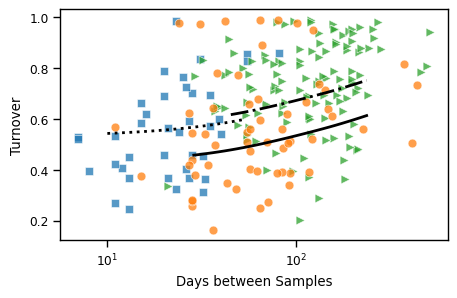

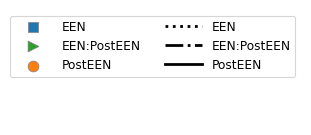

In [48]:
d1 = turnover_data
fit = obs_fit


# pair_type_palette = {'Transition': 'tab:green', 'EEN': 'tab:blue', 'PostEEN': 'tab:orange'}
# pair_type_marker_palette = {'EEN': 's', 'Transition': '>', 'PostEEN': 'o'}
# pair_type_linestyle_palette = {'EEN': ':', 'Transition': '--', 'PostEEN': '-'}

fig, ax = plt.subplots(figsize=(5, 3))
# ax.set_title("Within-subject Pairwise Turnover")
for pair_type in pair_type_order:
    d3 = d1[lambda x: (x.pair_type == pair_type)]
    ax.scatter(
        "time_delta",
        "diss",
        label="__nolegend__",
        data=d3,
        color=pair_type_palette[pair_type],
        marker=pair_type_marker_palette[pair_type],
        edgecolor="white",
        lw=0.5,
        alpha=0.75,
        s=40,
    )

_arbitrary_subject = d1.stratum.unique()[1]
predict_data = pd.DataFrame(
    product(
        [_arbitrary_subject],
        pair_type_order,
        np.logspace(1.0, 2.6),
    ),
    columns=["stratum", "pair_type", "time_delta"],
)
predict_data = predict_data.assign(
    prediction=fit.predict(predict_data),
    predict_mean_subject=lambda x: x.prediction
    - fit.params[f"C(stratum, Sum)[S.{_arbitrary_subject}]"],
)
for pair_type in pair_type_order:
    d4 = predict_data[lambda x: x.pair_type == pair_type]
    left, right = d1[lambda x: x.pair_type == pair_type].time_delta.quantile(
        [0.05, 0.95]
    )
    ax.plot(
        "time_delta",
        "predict_mean_subject",
        label="__nolegend__",
        data=d4[lambda x: (x.time_delta > left) & (x.time_delta < right)],
        color="black",
        linestyle=pair_type_linestyle_palette[pair_type],
        lw=2,
    )
ax.set_ylabel("Turnover")
ax.set_xlabel("Days between Samples")
ax.set_xscale("symlog", linthresh=1e-1)

fig.savefig("fig/een_turnover_analysis_strain_level.pdf", bbox_inches="tight")

fig, ax = plt.subplots(figsize=(2.5, 1.5))
for pair_type in pair_type_order:
    ax.scatter(
        [],
        [],
        label=pair_type,
        color=pair_type_palette[pair_type],
        marker=pair_type_marker_palette[pair_type],
        edgecolor="grey",
        lw=0.5,
        s=50,
    )
for pair_type in pair_type_order:
    ax.plot(
        [],
        [],
        label=pair_type,
        color="k",
        linestyle=pair_type_linestyle_palette[pair_type],
        lw=2,
    )
ax.legend(ncols=2, handlelength=3, markerscale=1.1)
lib.plot.hide_axes_and_spines(ax=ax)

fig.savefig("fig/een_turnover_analysis_legend.pdf", bbox_inches="tight")

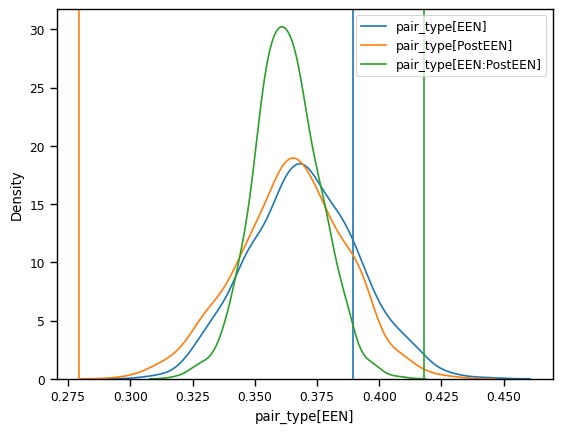

In [49]:
_obs = global_sotu_obs_coefs
_null = global_sotu_null_coefs

for coef, color in zip(coef_name_list, ["tab:blue", "tab:orange", "tab:green"]):
    sns.kdeplot(_null[coef], color=color)
    plt.axvline(_obs[coef], color=color, label=coef)
plt.legend()

0.256
0.002
0.008
0.002


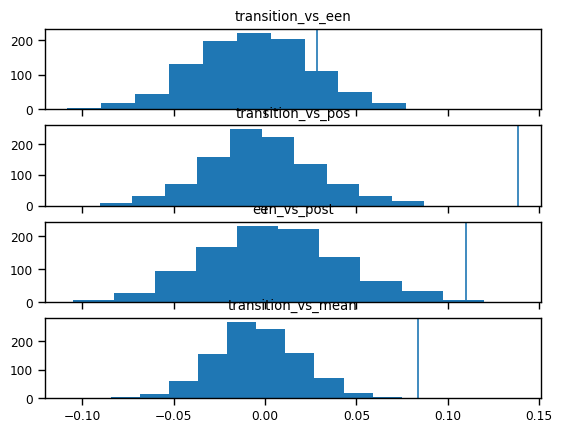

In [50]:
comparisons = dict(
    transition_vs_een=lambda x: x["pair_type[EEN:PostEEN]"] - x["pair_type[EEN]"],
    transition_vs_pos=lambda x: x["pair_type[EEN:PostEEN]"] - x["pair_type[PostEEN]"],
    een_vs_post=lambda x: x["pair_type[EEN]"] - x["pair_type[PostEEN]"],
    transition_vs_mean=lambda x: x["pair_type[EEN:PostEEN]"]
    - 0.5 * (x["pair_type[EEN]"] + x["pair_type[PostEEN]"]),
)

_obs = global_sotu_obs_coefs
_null = global_sotu_null_coefs


fig, axs = plt.subplots(4, sharex=True)
for comp, ax in zip(comparisons, axs):
    x, y = _null.apply(comparisons[comp], axis=1), comparisons[comp](_obs)
    ax.set_title(comp)
    ax.hist(x)
    ax.axvline(y)
    print(calculate_2tailed_pvalue_from_perm(y, x))

### Per-Species

In [51]:
species_turnover_analysis_details = {}
for species_id in tqdm(motu_rabund.columns):
    inpath = f"data/group/een/species/sp-{species_id}/r.proc.gtpro.sfacts-fit.world.nc"
    if not os.path.exists(inpath):
        print(species_id, "file missing")
        continue

    sf_fit = (
        sf.data.World.load(inpath)
        .rename_coords(sample=lambda s: "CF_{}".format(int(s.split("_")[1])))
        .rename_coords(sample={"CF_11": "CF_15", "CF_15": "CF_11"})
        # .drop_low_abundance_strains(0.01)
        # .rename_coords(strain=str)
    )

    comm = sf_fit.community.to_pandas()
    comm_bc_pdist = pd.DataFrame(
        squareform(pdist(comm, metric="braycurtis")),
        index=comm.index,
        columns=comm.index,
    )

    try:
        turnover_data = construct_turnover_analysis_data(
            comm_bc_pdist,
            meta=sample[lambda x: x.diet_or_media.isin(["EEN", "PostEEN"])],
            sample_type_var="diet_or_media",
            stratum_var="subject_id",
            time_var="collection_date_relative_een_end",
        )
    except ValueError:
        print(species_id, "data doesn't work")
        continue
    species_turnover_analysis_details[species_id] = pd.Series(
        dict(
            overall_mean_diss=turnover_data.groupby("stratum").diss.mean().mean(),
            num_pairs=turnover_data.shape[0],
            num_subjects_with_pairs=turnover_data.stratum.unique().shape[0],
            num_transition_pairs=turnover_data[
                lambda x: x.pair_type == "EEN:PostEEN"
            ].shape[0],
            num_subjects_with_transition_pairs=turnover_data[
                lambda x: x.pair_type == "EEN:PostEEN"
            ]
            .stratum.unique()
            .shape[0],
        )
    )

species_turnover_analysis_details = pd.DataFrame(
    species_turnover_analysis_details.values(),
    index=species_turnover_analysis_details.keys(),
)

  4%|██████▌                                                                                                                                                                     | 14/369 [00:01<00:50,  7.08it/s]

100060 file missing


 15%|█████████████████████████▏                                                                                                                                                  | 54/369 [00:08<01:08,  4.58it/s]

100189 file missing


 33%|███████████████████████████████████████████████████████▌                                                                                                                   | 120/369 [00:14<00:11, 21.13it/s]

100878 file missing


 36%|█████████████████████████████████████████████████████████████▋                                                                                                             | 133/369 [00:14<00:10, 23.15it/s]

101188 file missing


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 367/369 [00:40<00:00, 16.74it/s]

104404 data doesn't work


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 369/369 [00:40<00:00,  9.13it/s]


In [52]:
formula = "diss ~ 0 + pair_type + cr(time_delta, 4) + C(stratum, Sum)"
coef_name_list = ["pair_type[EEN]", "pair_type[PostEEN]", "pair_type[EEN:PostEEN]"]
n_perm = 999  # FIXME: Replace this with 999. Take about 40 minutes.

obs_coefs = {}
null_coef_dists = []
for species_id in tqdm(motu_rabund.columns):
    inpath = f"data/group/een/species/sp-{species_id}/r.proc.gtpro.sfacts-fit.world.nc"
    if not os.path.exists(inpath):
        print(species_id, "file missing")
        continue

    sf_fit = (
        sf.data.World.load(inpath)
        .rename_coords(sample=lambda s: "CF_{}".format(int(s.split("_")[1])))
        .rename_coords(sample={"CF_11": "CF_15", "CF_15": "CF_11"})
        # .drop_low_abundance_strains(0.01)
        # .rename_coords(strain=str)
    )

    comm = sf_fit.community.to_pandas()
    comm_bc_pdist = pd.DataFrame(
        squareform(pdist(comm, metric="braycurtis")),
        index=comm.index,
        columns=comm.index,
    )

    try:
        turnover_data = construct_turnover_analysis_data(
            comm_bc_pdist,
            meta=sample[lambda x: x.diet_or_media.isin(["EEN", "PostEEN"])],
            sample_type_var="diet_or_media",
            stratum_var="subject_id",
            time_var="collection_date_relative_een_end",
        )
    except ValueError:
        print(species_id, "data doesn't work")
        continue

    try:
        obs_fit = smf.ols(formula, data=turnover_data).fit()
    except ValueError:
        print(species_id, "fit failed")
        continue
    obs_coefs[species_id] = obs_fit.params.reindex(coef_name_list)

    np.random.seed(0)
    _null_coef_dists = []
    for _ in range(n_perm):
        perm_fit = smf.ols(
            formula,
            data=turnover_data.assign(
                pair_type=lambda x: x.groupby("stratum").pair_type.sample(frac=1).values
            ),
        ).fit()
        _null_coef_dists.append(perm_fit.params.reindex(coef_name_list))
    null_coef_dists.append(
        pd.DataFrame(_null_coef_dists, columns=coef_name_list).assign(
            species_id=species_id
        )
    )

per_species_obs_coefs = pd.DataFrame(obs_coefs).T
per_species_null_coefs = pd.concat(null_coef_dists)

  1%|▉                                                                                                                                                                            | 2/369 [00:12<37:11,  6.08s/it]

100014 fit failed


  4%|██████▉                                                                                                                                                                     | 15/369 [01:29<37:39,  6.38s/it]

100060 file missing


  7%|████████████▌                                                                                                                                                               | 27/369 [02:41<35:42,  6.27s/it]

100088 fit failed


 15%|█████████████████████████▏                                                                                                                                                  | 54/369 [05:30<35:36,  6.78s/it]

100189 file missing
100190 fit failed


 19%|█████████████████████████████████                                                                                                                                           | 71/369 [07:07<31:40,  6.38s/it]

100231 fit failed


 20%|██████████████████████████████████                                                                                                                                          | 73/369 [07:13<24:18,  4.93s/it]

100238 fit failed


 21%|███████████████████████████████████▍                                                                                                                                        | 76/369 [07:26<23:07,  4.74s/it]

100245 fit failed


 25%|██████████████████████████████████████████▉                                                                                                                                 | 92/369 [09:01<29:06,  6.31s/it]

100289 fit failed


 26%|████████████████████████████████████████████▎                                                                                                                               | 95/369 [09:13<23:15,  5.09s/it]

100323 fit failed


 29%|██████████████████████████████████████████████████                                                                                                                         | 108/369 [10:25<25:36,  5.89s/it]

100701 fit failed
100707 fit failed


 31%|█████████████████████████████████████████████████████▊                                                                                                                     | 116/369 [11:00<22:30,  5.34s/it]

100878 file missing


 33%|████████████████████████████████████████████████████████▌                                                                                                                  | 122/369 [11:29<21:58,  5.34s/it]

101029 fit failed


 34%|██████████████████████████████████████████████████████████▊                                                                                                                | 127/369 [11:53<21:28,  5.32s/it]

101088 fit failed


 35%|████████████████████████████████████████████████████████████▏                                                                                                              | 130/369 [12:05<18:45,  4.71s/it]

101151 fit failed
101160 fit failed


 36%|█████████████████████████████████████████████████████████████▋                                                                                                             | 133/369 [12:11<13:19,  3.39s/it]

101188 file missing


 37%|███████████████████████████████████████████████████████████████▉                                                                                                           | 138/369 [12:37<19:07,  4.97s/it]

101293 fit failed


 38%|█████████████████████████████████████████████████████████████████▎                                                                                                         | 141/369 [12:50<17:40,  4.65s/it]

101296 fit failed


 40%|████████████████████████████████████████████████████████████████████                                                                                                       | 147/369 [13:23<21:46,  5.88s/it]

101309 fit failed


 43%|██████████████████████████████████████████████████████████████████████████▏                                                                                                | 160/369 [14:42<23:03,  6.62s/it]

101354 fit failed


 45%|████████████████████████████████████████████████████████████████████████████▉                                                                                              | 166/369 [15:17<22:12,  6.57s/it]

101369 fit failed


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 201/369 [18:59<16:51,  6.02s/it]

101770 fit failed


 55%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 203/369 [19:04<12:33,  4.54s/it]

101820 fit failed


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 226/369 [21:18<14:14,  5.98s/it]

102292 fit failed


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 232/369 [21:47<12:35,  5.52s/it]

102320 fit failed


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 234/369 [21:53<09:54,  4.40s/it]

102322 fit failed


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 241/369 [22:33<12:20,  5.78s/it]

102363 fit failed


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 313/369 [29:51<05:39,  6.06s/it]

103217 fit failed


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 335/369 [32:00<03:22,  5.97s/it]

103949 fit failed


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 361/369 [34:31<00:48,  6.11s/it]

104404 data doesn't work


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 364/369 [34:43<00:24,  4.87s/it]

104491 fit failed


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 369/369 [35:06<00:00,  5.71s/it]


In [53]:
comparisons = dict(
    transition_vs_een=lambda x: x["pair_type[EEN:PostEEN]"] - x["pair_type[EEN]"],
    transition_vs_pos=lambda x: x["pair_type[EEN:PostEEN]"] - x["pair_type[PostEEN]"],
    een_vs_post=lambda x: x["pair_type[EEN]"] - x["pair_type[PostEEN]"],
    transition_vs_mean=lambda x: x["pair_type[EEN:PostEEN]"]
    - 0.5 * (x["pair_type[EEN]"] + x["pair_type[PostEEN]"]),
)

transition_stats_obs = per_species_obs_coefs.dropna().assign(**comparisons)
transition_stats_null = per_species_null_coefs.assign(**comparisons)
_stats = transition_stats_null.join(transition_stats_obs, on='species_id', lsuffix='_obs', rsuffix='_null', how='inner')

species_transition_test_pvalue = _stats.dropna().groupby('species_id').apply(lambda x: calculate_2tailed_pvalue_from_perm(x.transition_vs_mean_obs, x.transition_vs_mean_null))
# for species in per_species_obs_coefs.dropna().index:
#     print(calculate_2tailed_pvalue_from_perm(x, y))

(-2.5, 2.5)

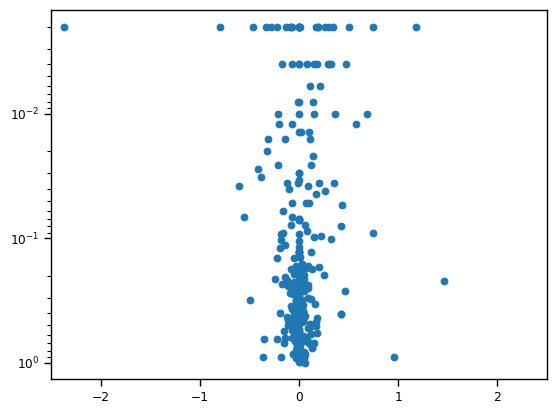

In [54]:
fig, ax = plt.subplots()

ax.scatter(transition_stats_obs.transition_vs_mean, species_transition_test_pvalue)
ax.set_yscale('log')
ax.yaxis.set_inverted(True)
ax.set_xlim(-2.5, 2.5)

## zOTU / Metagenomics Matching

In [55]:
from sklearn.cross_decomposition import PLSSVD


def plssvd_cross_mapping(x, y, scaled=False, transpose=False):
    if transpose:
        x, y = y, x
    pls = PLSSVD(n_components=min(*x.shape, *y.shape), scale=scaled).fit(x, y)
    cc = pd.DataFrame(
        pls.x_weights_ @ pls.y_weights_.T, index=x.columns, columns=y.columns
    )
    if transpose:
        cc = cc.T
    return cc, pls


def reciprocal_hits(x, y, score_func):
    x, y = align_indexes(x, y)

    coefs, aux = score_func(x, y)

    cols = coefs.columns
    idxs = coefs.index

    x_weight = np.sqrt((x.mean().loc[idxs]))
    y_weight = np.sqrt((y.mean().loc[cols]))
    weighted_coef = coefs.multiply(x_weight, axis=0).multiply(y_weight, axis=1)

    cols_rank = weighted_coef.rank(1, ascending=False)
    idxs_rank = weighted_coef.rank(0, ascending=False)

    result = (
        (cols_rank * idxs_rank)
        .stack()
        .to_frame("rank_product")
        .assign(coef=coefs.stack(), weighted_coef=weighted_coef.stack())
    )

    return result, coefs, aux

In [56]:
x, y = motu_rabund.copy(), rotu_rabund.copy()
print(len(x), len(y))

reciprocal_hits_results, cc, aux = reciprocal_hits(
    x,
    y,
    score_func=lambda x, y: plssvd_cross_mapping(x, y, scaled=False),
)
reciprocal_hits_results = (
    reciprocal_hits_results.join(motu_taxonomy[["f__", "g__", "s__"]], on="species_id")
    .join(rotu_taxonomy[["f__", "g__"]], lsuffix="mgen", rsuffix="zotu")
    .sort_values("zotu")
)


reciprocal_hits_results[lambda x: x.rank_product <= 2].sort_values(
    "zotu"
).rank_product.value_counts()

187 702


rank_product
1.0    71
2.0    45
Name: count, dtype: int64

In [57]:
reciprocal_hits_results[lambda x: x.rank_product <= 2].assign(
    g_mgen_norm=lambda x: x.g__mgen.str[3:].str.split("_").str[0],
    g_zotu_norm=lambda x: x.g__zotu.str.split("_").str[0],
    g_match=lambda x: x.g_mgen_norm == x.g_zotu_norm,
    f_mgen_norm=lambda x: x.f__mgen.str[3:].str.split("_").str[0],
    f_zotu_norm=lambda x: x.f__zotu.str.split("_").str[0],
    f_match=lambda x: x.f_mgen_norm == x.f_zotu_norm,
    matches=lambda x: (x.f_match | x.g_match),
).matches.mean()

0.8362068965517241

In [58]:
reciprocal_hits_results.xs("Zotu5", level="zotu").sort_values("rank_product").head(2)

,rank_product,coef,weighted_coef,f__mgen,g__mgen,s__,f__zotu,g__zotu
species_id,,,,,,,,
101493,1.0,0.727959,0.022412,f__Lachnospiraceae,g__Clostridium_M,s__Clostridium_M bolteae,Lachnospiraceae,Lachnoclostridium
101386,2.0,0.560360,0.020527,f__Lachnospiraceae,g__Clostridium_M,s__Clostridium_M clostridioforme,Lachnospiraceae,Lachnoclostridium


In [59]:
reciprocal_hits_filtered = reciprocal_hits_results[
    lambda x: x.rank_product <= 2
].assign(
    g_mgen_norm=lambda x: x.g__mgen.str[3:].str.split("_").str[0],
    g_zotu_norm=lambda x: x.g__zotu.str.split("_").str[0],
    g_match=lambda x: x.g_mgen_norm == x.g_zotu_norm,
    f_mgen_norm=lambda x: x.f__mgen.str[3:].str.split("_").str[0],
    f_zotu_norm=lambda x: x.f__zotu.str.split("_").str[0],
    f_match=lambda x: x.f_mgen_norm == x.f_zotu_norm,
)[
    lambda x: (x.f_match | x.g_match)
]
reciprocal_hits_filtered

,,rank_product,coef,weighted_coef,f__mgen,g__mgen,s__,f__zotu,g__zotu,g_mgen_norm,g_zotu_norm,g_match,f_mgen_norm,f_zotu_norm,f_match
species_id,zotu,,,,,,,,,,,,,,
102478,Zotu1,1.0,0.821230,0.046545,f__Bacteroidaceae,g__Bacteroides_B,s__Bacteroides_B dorei,Bacteroidaceae,Bacteroides,Bacteroides,Bacteroides,True,Bacteroidaceae,Bacteroidaceae,True
100032,Zotu10,1.0,0.933079,0.024393,f__Lachnospiraceae,g__Hungatella,s__Hungatella effluvii,Lachnospiraceae,,Hungatella,,False,Lachnospiraceae,Lachnospiraceae,True
100062,Zotu100,1.0,0.603101,0.000824,f__Peptostreptococcaceae,g__Intestinibacter,s__Intestinibacter bartlettii,Peptostreptococcaceae,Intestinibacter,Intestinibacter,Intestinibacter,True,Peptostreptococcaceae,Peptostreptococcaceae,True
102327,Zotu103,2.0,0.200091,0.000520,f__Oscillospiraceae,g__Oscillibacter,s__Oscillibacter sp900066435,Oscillospiraceae,Oscillibacter,Oscillibacter,Oscillibacter,True,Oscillospiraceae,Oscillospiraceae,True
100562,Zotu106,1.0,0.539228,0.001136,f__Lachnospiraceae,g__Lachnospira,s__Lachnospira sp000437735,Lachnospiraceae,Lachnospira,Lachnospira,Lachnospira,True,Lachnospiraceae,Lachnospiraceae,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102351,Zotu94,2.0,0.633493,0.001547,f__Enterobacteriaceae,g__Klebsiella_A,s__Klebsiella_A michiganensis,Enterobacteriaceae,Klebsiella,Klebsiella,Klebsiella,True,Enterobacteriaceae,Enterobacteriaceae,True
101361,Zotu95,1.0,0.472618,0.002099,f__Burkholderiaceae,g__Sutterella,s__Sutterella wadsworthensis_B,Sutterellaceae,Sutterella,Sutterella,Sutterella,True,Burkholderiaceae,Sutterellaceae,False
102538,Zotu96,1.0,0.449833,0.002618,f__Enterobacteriaceae,g__Klebsiella,s__Klebsiella pneumoniae,Enterobacteriaceae,Klebsiella,Klebsiella,Klebsiella,True,Enterobacteriaceae,Enterobacteriaceae,True


#### Supplementary Table S3

In [60]:
d = reciprocal_hits_filtered.join(motu_taxonomy.s__.rename('uhgg_taxonomy')).assign(
    coefficient=lambda x: x.coef.round(3),
    weighted_coefficient=lambda x: x.weighted_coef.round(3),
    rank_product=lambda x: x.rank_product.astype(int),
    uhgg_url=lambda x: "https://www.ebi.ac.uk/metagenomics/genomes/MGYG0000" + x.index.to_frame().species_id.str[1:],
    ezbc_id='',
    network_association='',
)[['coefficient', 'weighted_coefficient', 'rank_product', 'uhgg_taxonomy', 'uhgg_url', 'ezbc_id', 'network_association']]

d.to_csv('fig/een_supplementary_table_s3.tsv', sep='\t')
d

,,coefficient,weighted_coefficient,rank_product,uhgg_taxonomy,uhgg_url,ezbc_id,network_association
species_id,zotu,,,,,,,
102478,Zotu1,0.821,0.047,1,s__Bacteroides_B dorei,https://www.ebi.ac.uk/metagenomics/genomes/MGY...,,
100032,Zotu10,0.933,0.024,1,s__Hungatella effluvii,https://www.ebi.ac.uk/metagenomics/genomes/MGY...,,
100062,Zotu100,0.603,0.001,1,s__Intestinibacter bartlettii,https://www.ebi.ac.uk/metagenomics/genomes/MGY...,,
102327,Zotu103,0.200,0.001,2,s__Oscillibacter sp900066435,https://www.ebi.ac.uk/metagenomics/genomes/MGY...,,
100562,Zotu106,0.539,0.001,1,s__Lachnospira sp000437735,https://www.ebi.ac.uk/metagenomics/genomes/MGY...,,
...,...,...,...,...,...,...,...,...
102351,Zotu94,0.633,0.002,2,s__Klebsiella_A michiganensis,https://www.ebi.ac.uk/metagenomics/genomes/MGY...,,
101361,Zotu95,0.473,0.002,1,s__Sutterella wadsworthensis_B,https://www.ebi.ac.uk/metagenomics/genomes/MGY...,,
102538,Zotu96,0.450,0.003,1,s__Klebsiella pneumoniae,https://www.ebi.ac.uk/metagenomics/genomes/MGY...,,


In [61]:
# How many zOTUs or species, and what fraction of relative abundance do these account for?
d.index.to_frame().zotu.unique().shape, d.index.to_frame().species_id.unique().shape, rotu_rabund[d.index.to_frame().zotu.values].sum(1).median()

((92,), (86,), 0.7561409126022939)

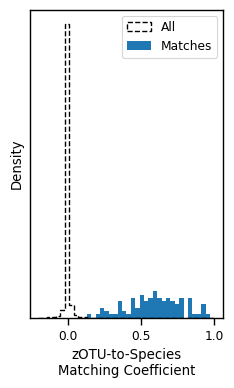

In [62]:
fig, ax = plt.subplots(figsize=(2.5, 4))

bins = np.linspace(-0.2, 1.0, num=41)
plt.hist(
    reciprocal_hits_results.coef,
    density=True,
    bins=bins,
    histtype="step",
    color="k",
    lw=1,
    linestyle="--",
    label="All",
    zorder=2,
)
plt.hist(
    reciprocal_hits_filtered.coef,
    density=True,
    bins=bins,
    color="tab:blue",
    label="Matches",
    zorder=1,
)
plt.yticks([])
plt.xlabel("zOTU-to-Species\nMatching Coefficient")
plt.ylabel('Density')
plt.legend()
plt.savefig("fig/een_species_matching_correlation_density.pdf", bbox_inches="tight")

#### zOTU5

PearsonRResult(statistic=0.7224494939621168, pvalue=1.8177987299497327e-31)
PearsonRResult(statistic=0.6771281777359678, pvalue=1.9591250765987947e-26)
PearsonRResult(statistic=0.9023454677857894, pvalue=1.5584107844680288e-69)


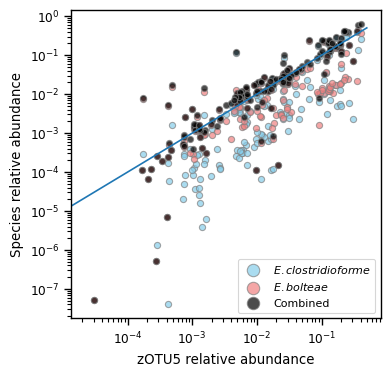

In [63]:
d = pd.DataFrame(
    dict(
        rotu=rotu_rabund[["Zotu5"]].sum(1),
        motu_A=motu_rabund[["101386"]].sum(1),
        motu_B=motu_rabund[["101493"]].sum(1),
        motu_both=motu_rabund[["101493", "101386"]].sum(1),
    )
).dropna()
print(sp.stats.pearsonr(d["motu_A"], d["rotu"]))
print(sp.stats.pearsonr(d["motu_B"], d["rotu"]))
print(sp.stats.pearsonr(d["motu_both"], d["rotu"]))

fig, ax = plt.subplots(figsize=(4, 4))
plt.scatter(
    "rotu",
    "motu_A",
    data=d,
    label="$\mathit{E. clostridioforme}$",
    s=20,
    alpha=0.7,
    edgecolor="grey",
    color="skyblue",
)
plt.scatter(
    "rotu",
    "motu_B",
    data=d,
    label="$\mathit{E. bolteae}$",
    s=20,
    alpha=0.7,
    edgecolor="grey",
    color="lightcoral",
)
plt.scatter(
    "rotu",
    "motu_both",
    data=d,
    label="Combined",
    s=20,
    alpha=0.7,
    edgecolor="grey",
    color="black",
)
plt.plot([0, 0.5], [0, 0.5])
plt.xlabel("zOTU5 relative abundance")
plt.ylabel("Species relative abundance")
plt.yscale("log")
plt.xscale("log")
# plt.ylim(1e-8, 5e1)
# ax.set_aspect(1)
plt.legend(loc="lower right", fontsize="small", markerscale=2)

plt.savefig("fig/een_zotu5_species_matching.pdf", bbox_inches="tight")

#### sp-101346 (B. uniformis)

PearsonRResult(statistic=0.4095193223873651, pvalue=5.8916513727057385e-09)
PearsonRResult(statistic=0.5000146893895572, pvalue=3.1948792082551934e-13)
PearsonRResult(statistic=0.6626353486367248, pvalue=5.20605208079608e-25)


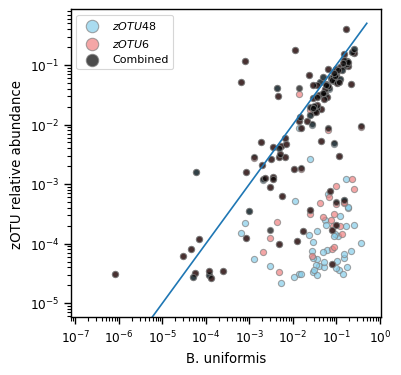

In [64]:
d = pd.DataFrame(
    dict(
        rotu_A=rotu_rabund[["Zotu48"]].sum(1),
        rotu_B=rotu_rabund[["Zotu6"]].sum(1),
        # rotu_C=rotu_rabund[["Zotu84"]].sum(1),
        motu=motu_rabund[["101346"]].sum(1),
        rotu_both=rotu_rabund[["Zotu6", "Zotu48"]].sum(1),
    )
).dropna()
print(sp.stats.pearsonr(d["rotu_A"], d["motu"]))
print(sp.stats.pearsonr(d["rotu_B"], d["motu"]))
# print(sp.stats.pearsonr(d["rotu_C"], d["motu"]))
print(sp.stats.pearsonr(d["rotu_both"], d["motu"]))

fig, ax = plt.subplots(figsize=(4, 4))
plt.scatter(
    "motu",
    "rotu_A",
    data=d,
    label="$\mathit{zOTU48}$",
    s=20,
    alpha=0.7,
    edgecolor="grey",
    color="skyblue",
)
plt.scatter(
    "motu",
    "rotu_B",
    data=d,
    label="$\mathit{zOTU6}$",
    s=20,
    alpha=0.7,
    edgecolor="grey",
    color="lightcoral",
)
# plt.scatter(
#     "motu",
#     "rotu_C",
#     data=d,
#     label="$\mathit{zOTU84}$",
#     s=20,
#     alpha=0.7,
#     edgecolor="grey",
#     color="lightgreen",
# )
plt.scatter(
    "motu",
    "rotu_both",
    data=d,
    label="Combined",
    s=20,
    alpha=0.7,
    edgecolor="grey",
    color="black",
)
plt.plot([0, 0.5], [0, 0.5])
plt.xlabel("B. uniformis")
plt.ylabel("zOTU relative abundance")
plt.yscale("log")
plt.xscale("log")
# plt.ylim(1e-8, 5e1)
# ax.set_aspect(1)
plt.legend(loc="upper left", fontsize="small", markerscale=2)

plt.savefig("fig/een_101346_zotu_matching.pdf", bbox_inches="tight")

## Per-Species Strain Time-Series

#### 101493

In [87]:
species = "101493"


print(motu_taxonomy.loc[species])

d__                 d__Bacteria
p__             p__Firmicutes_A
c__               c__Clostridia
o__           o__Lachnospirales
f__          f__Lachnospiraceae
g__            g__Clostridium_M
s__    s__Clostridium_M bolteae
Name: 101493, dtype: object


In [88]:
strain_fit = (
    sf.data.World.load(
        f"data/group/een/species/sp-{species}/r.proc.gtpro.sfacts-fit.world.nc"
    )
    .rename_coords(sample=lambda s: "CF_{}".format(int(s.split("_")[1])))
    .rename_coords(sample={"CF_11": "CF_15", "CF_15": "CF_11"})
    .drop_low_abundance_strains(0.2)
    .rename_coords(strain=str)
)
print(strain_fit.sizes)

# Genotype similarity ordered palette:
strain_linkage = strain_fit.genotype.linkage(optimal_ordering=True)
strain_order = list(
    linkage_order(
        strain_linkage,
        strain_fit.strain.values,
    )
)
strain_order.remove("-1")  # Drop "other" strain.
strain_order.append("-1")  # Add to end of list
strain_palette = lib.plot.construct_ordered_palette(
    strain_order,
    cm="rainbow",
    extend={"-1": "silver"},
)

sf.evaluation.metagenotype_error2(strain_fit, discretized=True)[0]

Frozen({'strain': 38, 'position': 10000, 'sample': 147, 'allele': 2})


0.025170719251036644

/include/StrainFacts/sfacts/plot.py:163: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(row_col_annotation_cmap)
/include/StrainFacts/sfacts/plot.py:175: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(row_col_annotation_cmap)


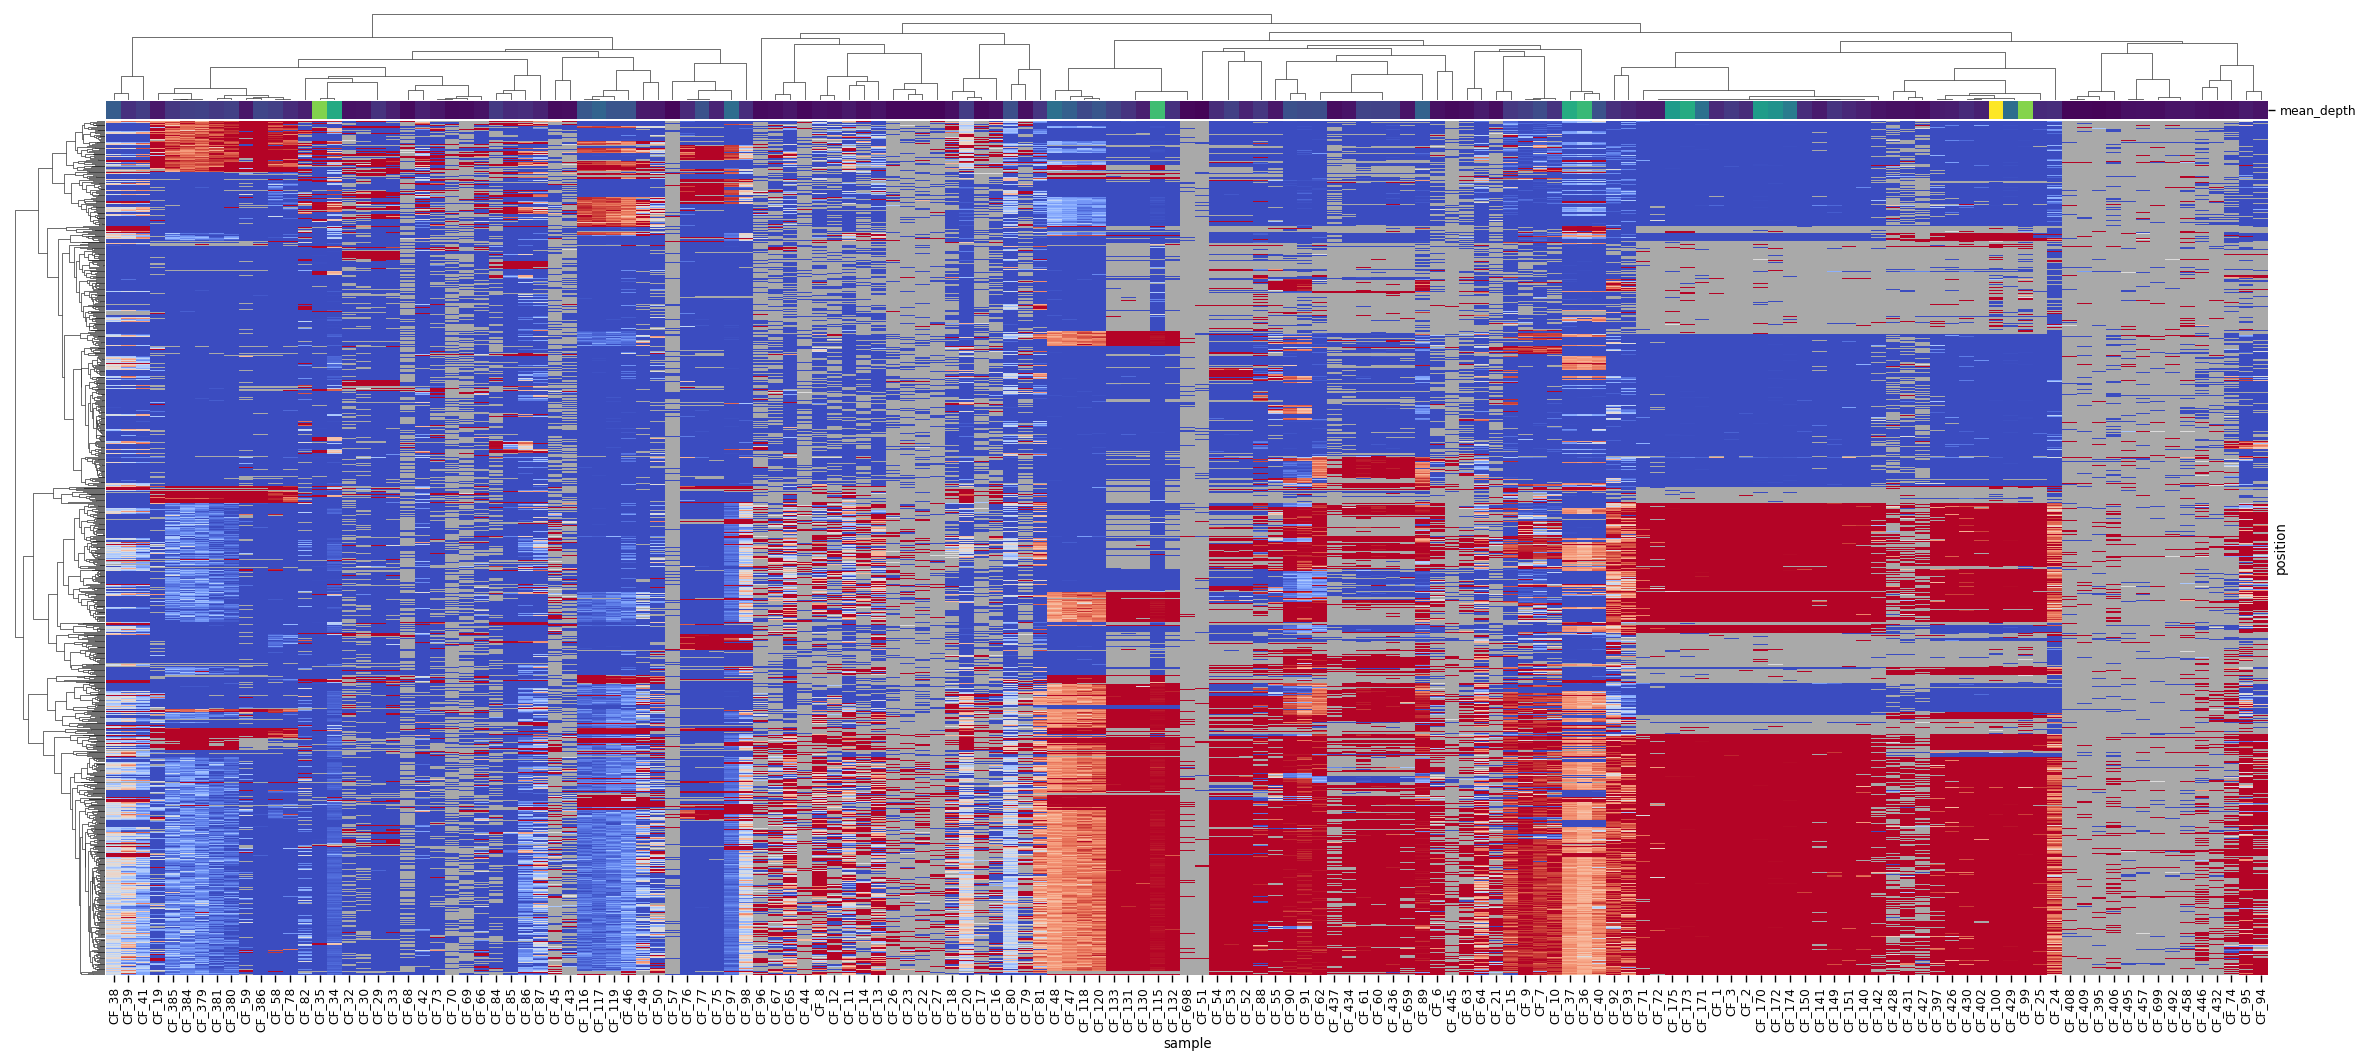

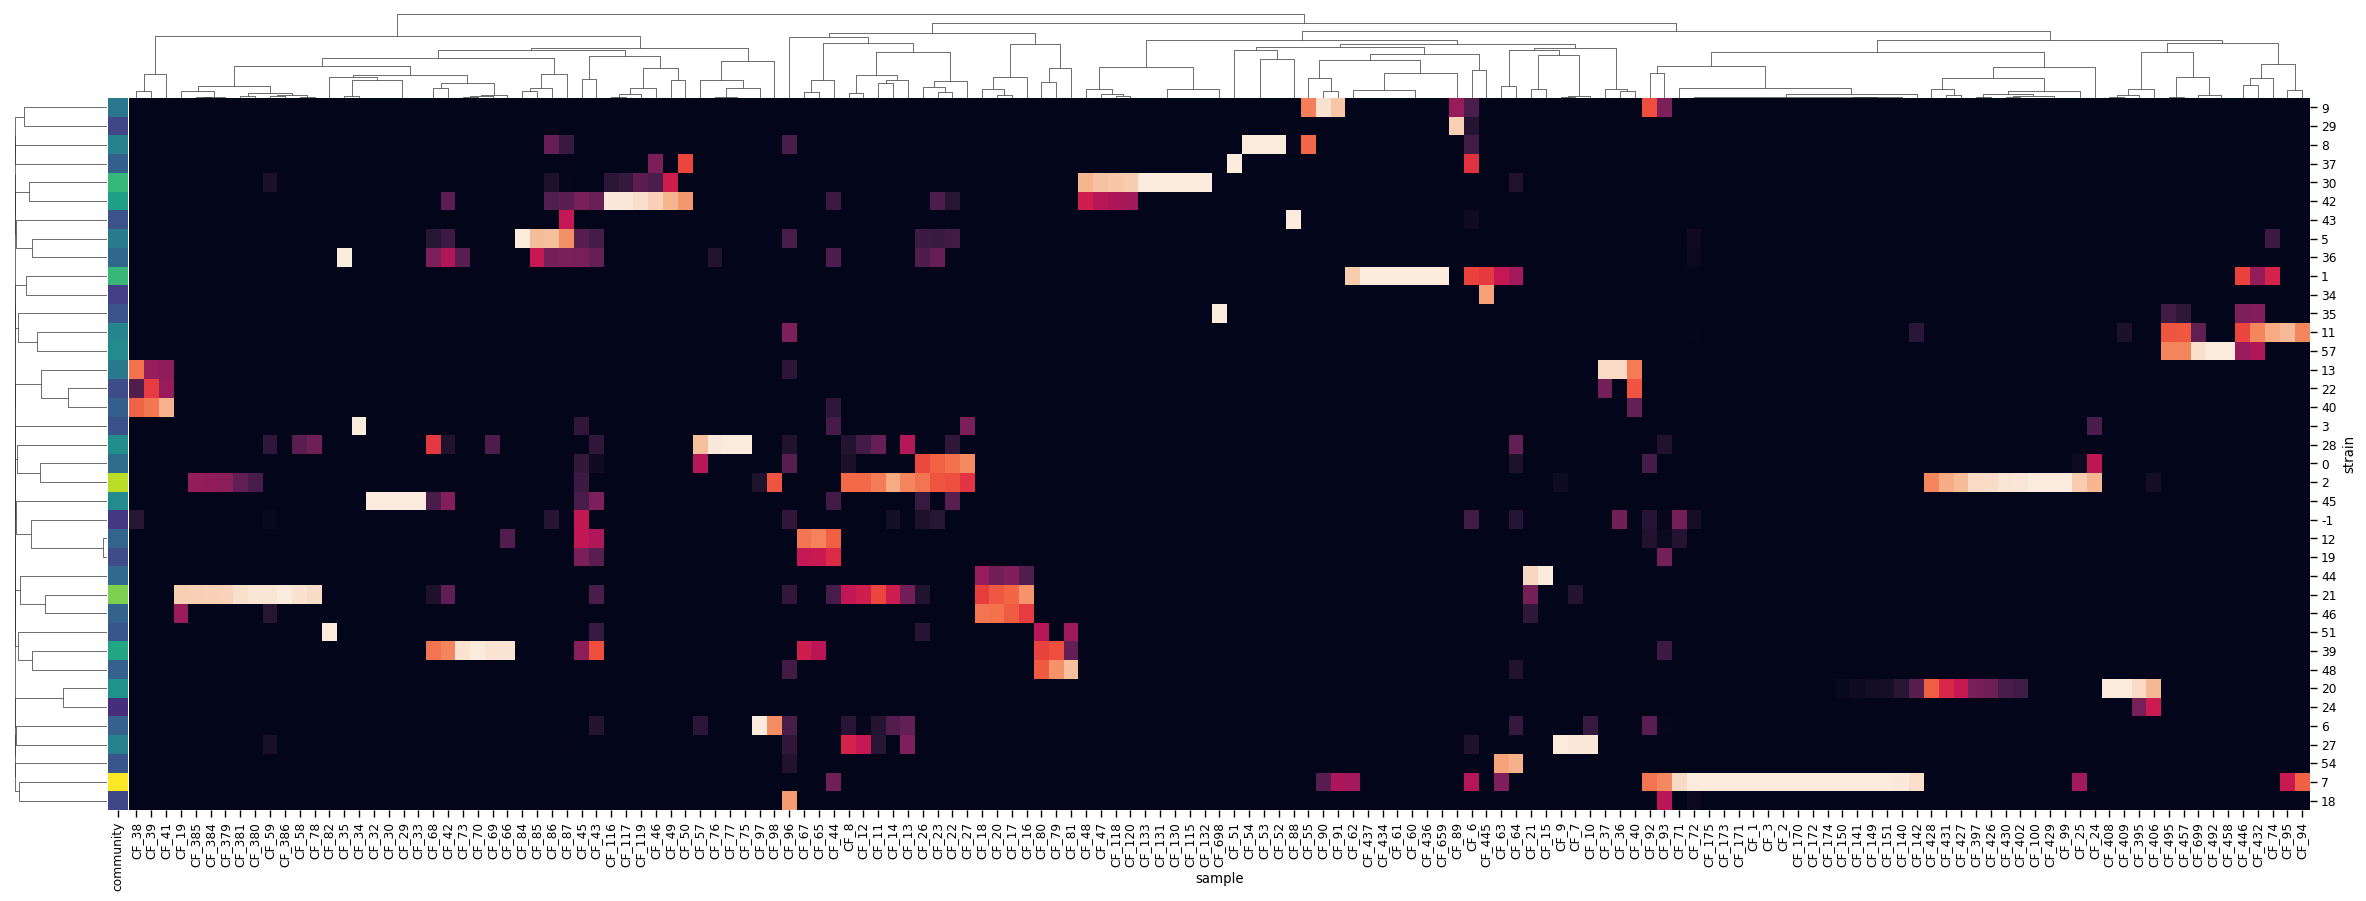

In [89]:
np.random.seed(0)

sample_linkage = strain_fit.unifrac_linkage(optimal_ordering=True)
position_ss = strain_fit.random_sample(
    position=min(strain_fit.sizes["position"], 1000)
).position

sf.plot.plot_metagenotype(
    strain_fit.sel(position=position_ss), col_linkage_func=lambda w: sample_linkage
)
sf.plot.plot_community(strain_fit, col_linkage_func=lambda w: sample_linkage)

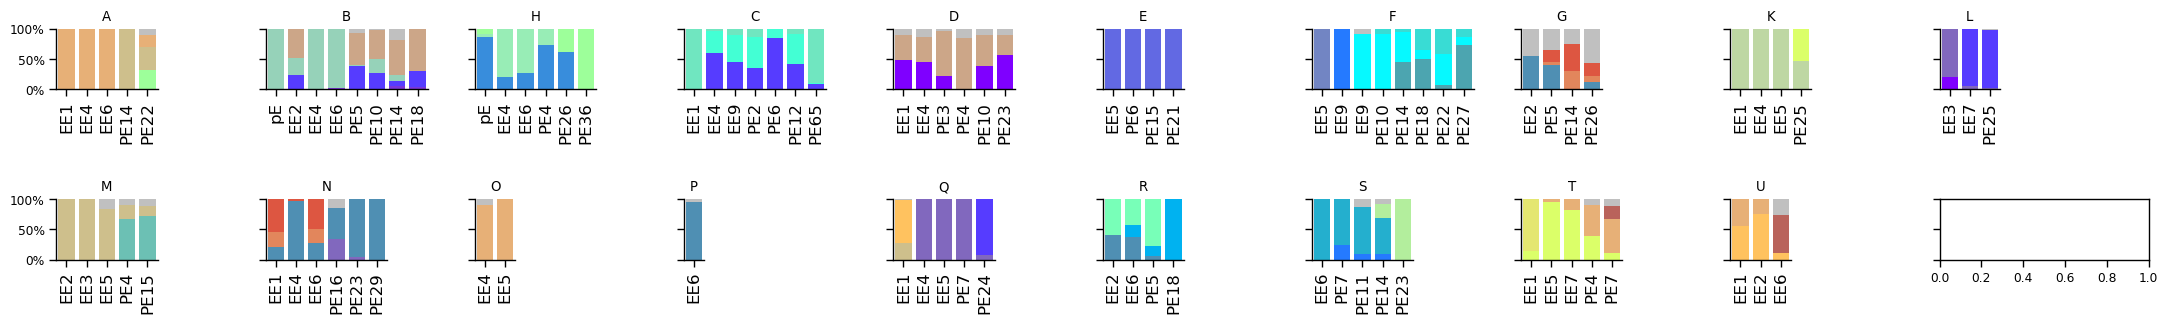

In [90]:
more_colors_strain_palette = lib.plot.construct_ordered_palette(
    strain_order,  # Linkage order, I believe
    cm="rainbow",
    extend={"-1": "silver"},
    desaturate_levels=[1.0, 0.7, 0.4],
)


sample.timepoint.map(rename_timepoints_for_ts)

fig, axs = plt.subplots(
    2,
    10,
    figsize=(10 * 2.7, 2 * 1.5),
    squeeze=False,
    sharey=True,
    gridspec_kw=dict(hspace=1.8, wspace=0),
)


for subject, ax in zip(subject_order, axs.flatten()):
    subject_comm_sample_list = list(
        set(idxwhere(sample.subject_id == subject)) & set(strain_fit.sample.values)
    )

    try:
        subject_comm = (
            strain_fit.sel(sample=subject_comm_sample_list)
            .drop_low_abundance_strains(0.2, agg_strain_coord="-1")
            .community.to_pandas()
        )
    except ValueError:
        subject_comm = pd.DataFrame([], columns=["-1"])

    sample_list = sample.sort_values("collection_date_relative_een_end")[
        lambda x: (x.subject_id == subject)
        & (x.sample_type == "human")
        & (x.index.isin(subject_comm.index))
    ].index

    if len(sample_list) == 0:
        lib.plot.hide_axes_and_spines(ax=ax)
        continue

    d = (
        sample.reindex(sample_list)
        # .dropna(subset=["collection_date_relative_een_end"])
        # .sort_values("collection_date_relative_een_end")
        .assign(
            t=lambda x: range(len(x)),
        )
    ).join(subject_comm)
    # d.loc[d.index[:num_offset_samples], 't'] -= 0.7  # Offset width

    plot_stacked_barplot(
        data=d,
        x_var="t",
        order=[s for s in strain_order if s in subject_comm.columns],
        palette=more_colors_strain_palette,
        ax=ax,
        width=0.8,
        lw=0,
    )

    ax.set_title(subject)
    ax.set_xticklabels(
        d.timepoint.map(rename_timepoints_for_ts),
        fontsize=12,
    )
    ax.set_aspect(3, anchor="NW")
    ax.set_ylim(0, 1.0)
    lib.plot.rotate_xticklabels(rotation=90, ax=ax, ha="center")
    ax.set_yticks(np.linspace(0, 1.0, num=3))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, symbol="%"))
    ax.set_xlim(d.t.min() - 0.5, d.t.max() + 0.5)
    ax.spines[["right", "top"]].set_visible(False)
    # ax.legend(bbox_to_anchor=(1, 1), ncols=2)

fig.savefig(f"fig/een.strain_timeseries.{species}.pdf", bbox_inches="tight")

### 101386

In [91]:
species = "101386"


print(motu_taxonomy.loc[species])

d__                         d__Bacteria
p__                     p__Firmicutes_A
c__                       c__Clostridia
o__                   o__Lachnospirales
f__                  f__Lachnospiraceae
g__                    g__Clostridium_M
s__    s__Clostridium_M clostridioforme
Name: 101386, dtype: object


In [92]:
strain_fit = (
    sf.data.World.load(
        f"data/group/een/species/sp-{species}/r.proc.gtpro.sfacts-fit.world.nc"
    )
    .rename_coords(sample=lambda s: "CF_{}".format(int(s.split("_")[1])))
    .rename_coords(sample={"CF_11": "CF_15", "CF_15": "CF_11"})
    .drop_low_abundance_strains(0.2)
    .rename_coords(strain=str)
)
print(strain_fit.sizes)

# Genotype similarity ordered palette:
strain_linkage = strain_fit.genotype.linkage(optimal_ordering=True)
strain_order = list(
    linkage_order(
        strain_linkage,
        strain_fit.strain.values,
    )
)
strain_order.remove("-1")  # Drop "other" strain.
strain_order.append("-1")  # Add to end of list
strain_palette = lib.plot.construct_ordered_palette(
    strain_order,
    cm="rainbow",
    extend={"-1": "silver"},
)

sf.evaluation.metagenotype_error2(strain_fit, discretized=True)[0]

Frozen({'strain': 18, 'position': 10000, 'sample': 114, 'allele': 2})


0.001997650135308504

/include/StrainFacts/sfacts/plot.py:163: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(row_col_annotation_cmap)
/include/StrainFacts/sfacts/plot.py:175: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(row_col_annotation_cmap)


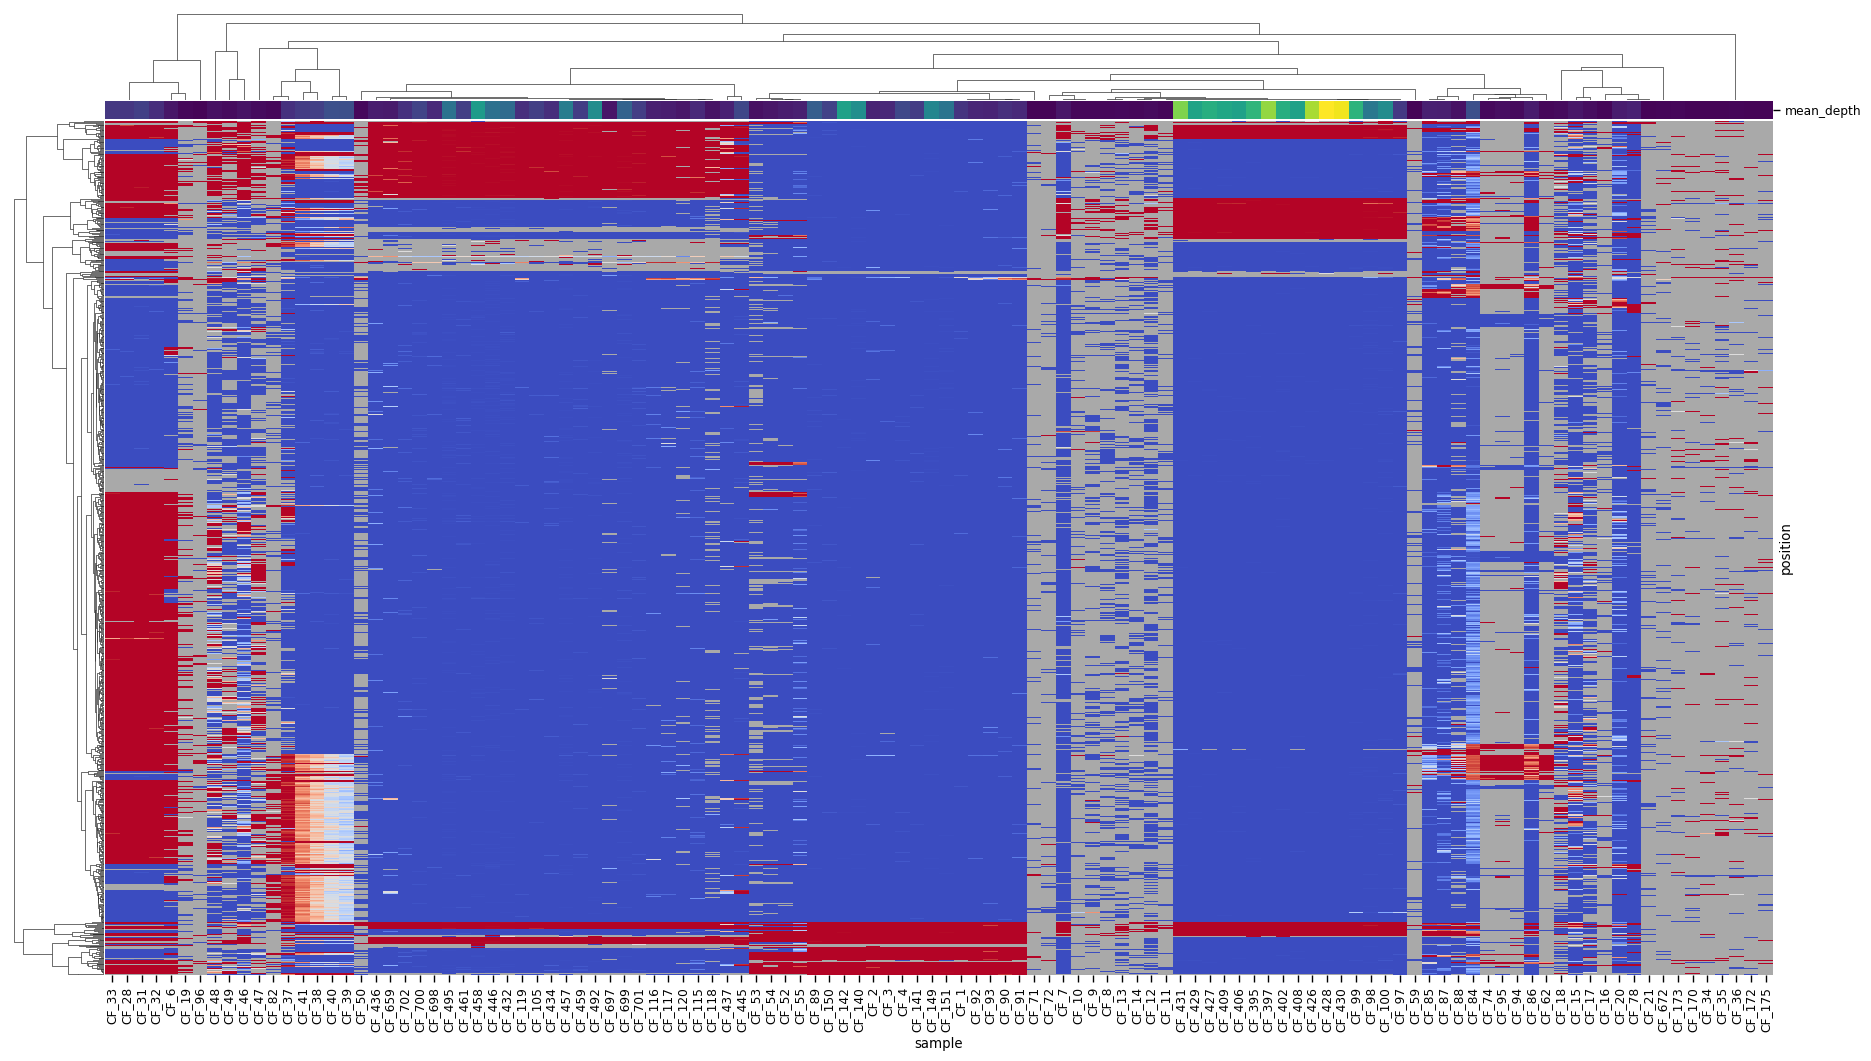

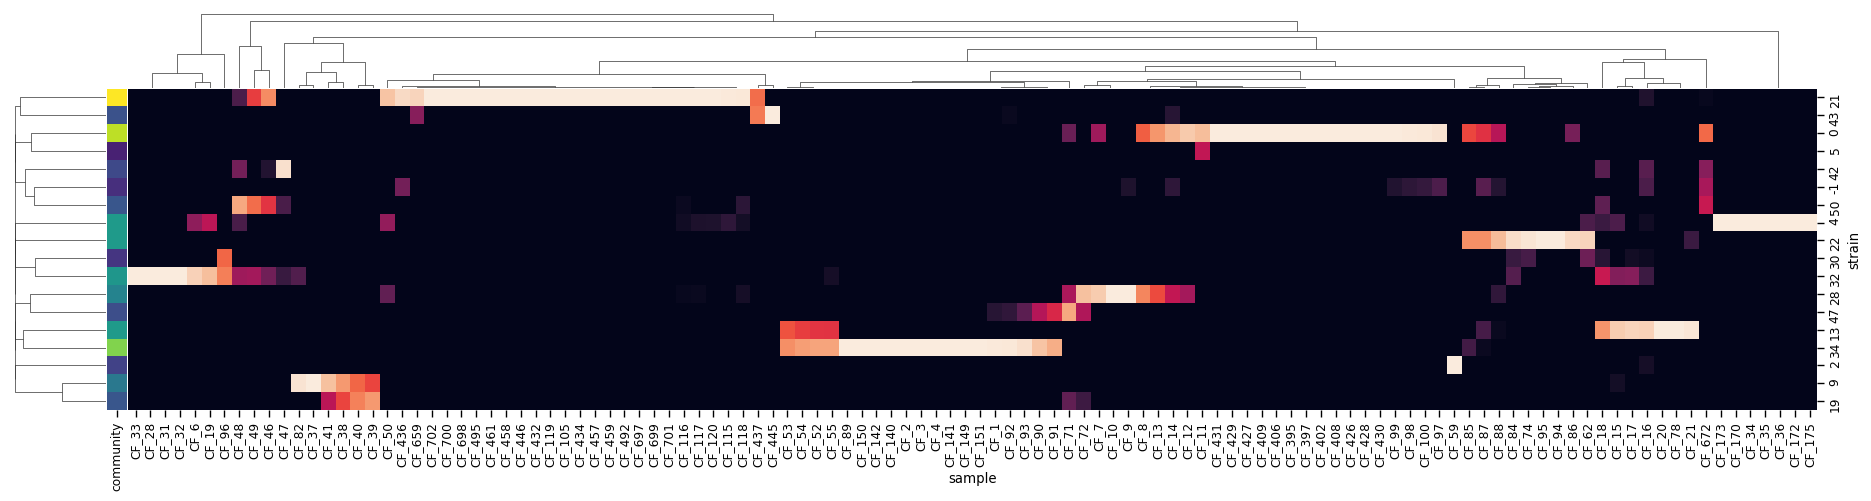

In [93]:
np.random.seed(0)

sample_linkage = strain_fit.unifrac_linkage(optimal_ordering=True)
position_ss = strain_fit.random_sample(
    position=min(strain_fit.sizes["position"], 1000)
).position

sf.plot.plot_metagenotype(
    strain_fit.sel(position=position_ss), col_linkage_func=lambda w: sample_linkage
)
sf.plot.plot_community(strain_fit, col_linkage_func=lambda w: sample_linkage)

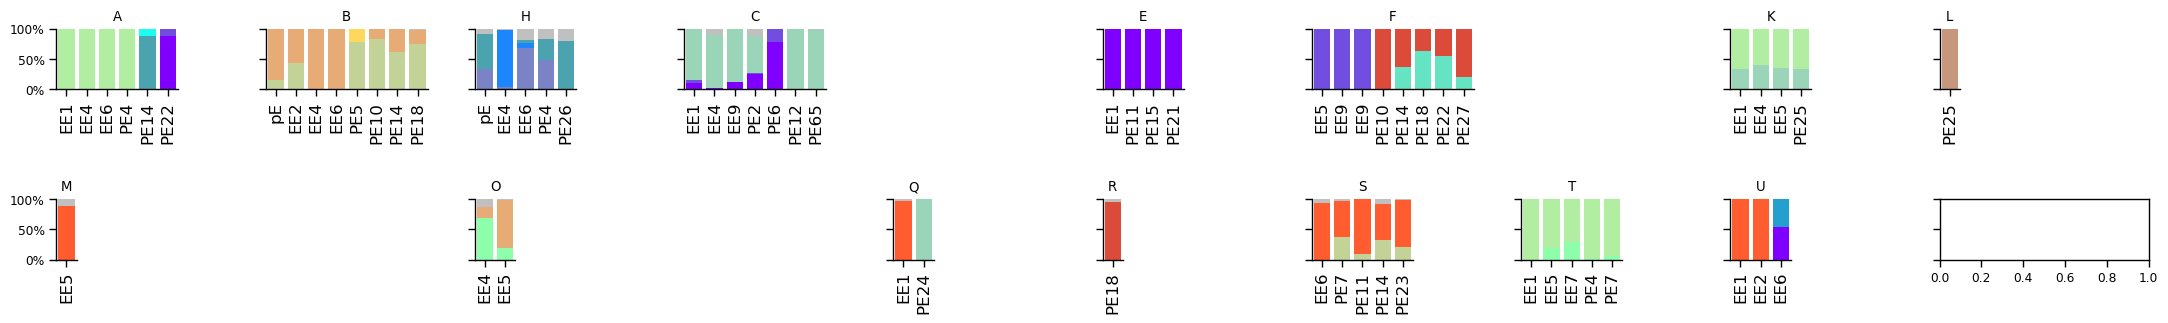

In [94]:
more_colors_strain_palette = lib.plot.construct_ordered_palette(
    strain_order,  # Linkage order, I believe
    cm="rainbow",
    extend={"-1": "silver"},
    desaturate_levels=[1.0, 0.7, 0.4],
)


sample.timepoint.map(rename_timepoints_for_ts)

fig, axs = plt.subplots(
    2,
    10,
    figsize=(10 * 2.7, 2 * 1.5),
    squeeze=False,
    sharey=True,
    gridspec_kw=dict(hspace=1.8, wspace=0),
)


for subject, ax in zip(subject_order, axs.flatten()):
    subject_comm_sample_list = list(
        set(idxwhere(sample.subject_id == subject)) & set(strain_fit.sample.values)
    )

    try:
        subject_comm = (
            strain_fit.sel(sample=subject_comm_sample_list)
            .drop_low_abundance_strains(0.2, agg_strain_coord="-1")
            .community.to_pandas()
        )
    except ValueError:
        subject_comm = pd.DataFrame([], columns=["-1"])

    sample_list = sample.sort_values("collection_date_relative_een_end")[
        lambda x: (x.subject_id == subject)
        & (x.sample_type == "human")
        & (x.index.isin(subject_comm.index))
    ].index

    if len(sample_list) == 0:
        lib.plot.hide_axes_and_spines(ax=ax)
        continue

    d = (
        sample.reindex(sample_list)
        # .dropna(subset=["collection_date_relative_een_end"])
        # .sort_values("collection_date_relative_een_end")
        .assign(
            t=lambda x: range(len(x)),
        )
    ).join(subject_comm)
    # d.loc[d.index[:num_offset_samples], 't'] -= 0.7  # Offset width

    plot_stacked_barplot(
        data=d,
        x_var="t",
        order=[s for s in strain_order if s in subject_comm.columns],
        palette=more_colors_strain_palette,
        ax=ax,
        width=0.8,
        lw=0,
    )

    ax.set_title(subject)
    ax.set_xticklabels(
        d.timepoint.map(rename_timepoints_for_ts),
        fontsize=12,
    )
    ax.set_aspect(3, anchor="NW")
    ax.set_ylim(0, 1.0)
    lib.plot.rotate_xticklabels(rotation=90, ax=ax, ha="center")
    ax.set_yticks(np.linspace(0, 1.0, num=3))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, symbol="%"))
    ax.set_xlim(d.t.min() - 0.5, d.t.max() + 0.5)
    ax.spines[["right", "top"]].set_visible(False)
    # ax.legend(bbox_to_anchor=(1, 1), ncols=2)

fig.savefig(f"fig/een.strain_timeseries.{species}.pdf", bbox_inches="tight")

### 102506

In [95]:
species = "102506"


print(motu_taxonomy.loc[species])

d__               d__Bacteria
p__         p__Proteobacteria
c__    c__Gammaproteobacteria
o__       o__Enterobacterales
f__     f__Enterobacteriaceae
g__            g__Escherichia
s__     s__Escherichia coli_D
Name: 102506, dtype: object


In [96]:
strain_fit = (
    sf.data.World.load(
        f"data/group/een/species/sp-{species}/r.proc.gtpro.sfacts-fit.world.nc"
    )
    .rename_coords(sample=lambda s: "CF_{}".format(int(s.split("_")[1])))
    .rename_coords(sample={"CF_11": "CF_15", "CF_15": "CF_11"})
    .drop_low_abundance_strains(0.2)
    .rename_coords(strain=str)
)
print(strain_fit.sizes)

# Genotype similarity ordered palette:
strain_linkage = strain_fit.genotype.linkage(optimal_ordering=True)
strain_order = list(
    linkage_order(
        strain_linkage,
        strain_fit.strain.values,
    )
)
strain_order.remove("-1")  # Drop "other" strain.
strain_order.append("-1")  # Add to end of list
strain_palette = lib.plot.construct_ordered_palette(
    strain_order,
    cm="rainbow",
    extend={"-1": "silver"},
)

sf.evaluation.metagenotype_error2(strain_fit, discretized=True)[0]

Frozen({'strain': 34, 'position': 10000, 'sample': 158, 'allele': 2})


0.013929834589362144

/include/StrainFacts/sfacts/plot.py:163: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(row_col_annotation_cmap)
/include/StrainFacts/sfacts/plot.py:175: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(row_col_annotation_cmap)


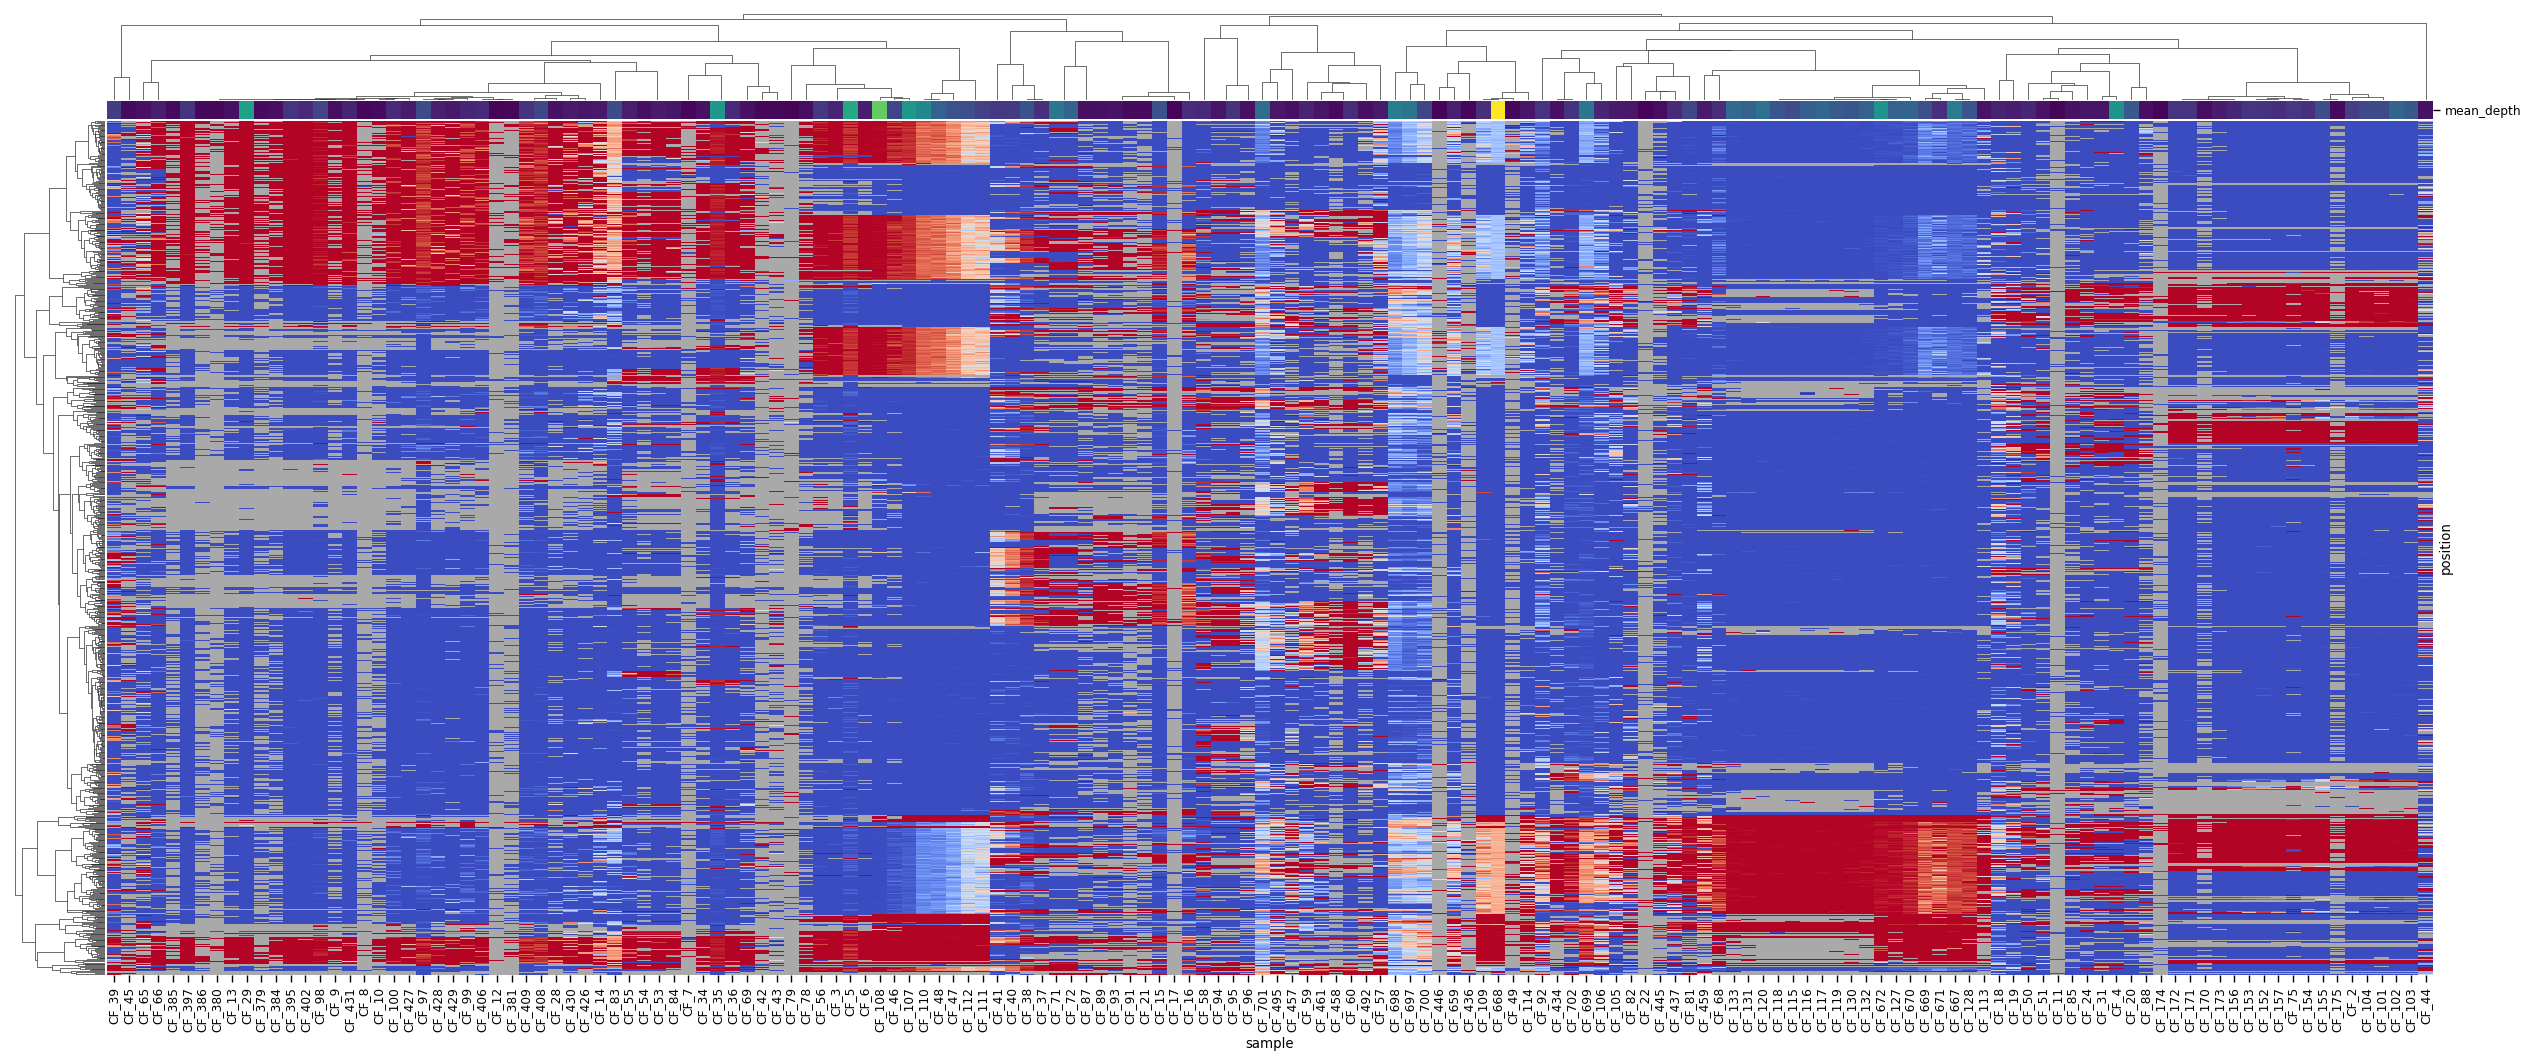

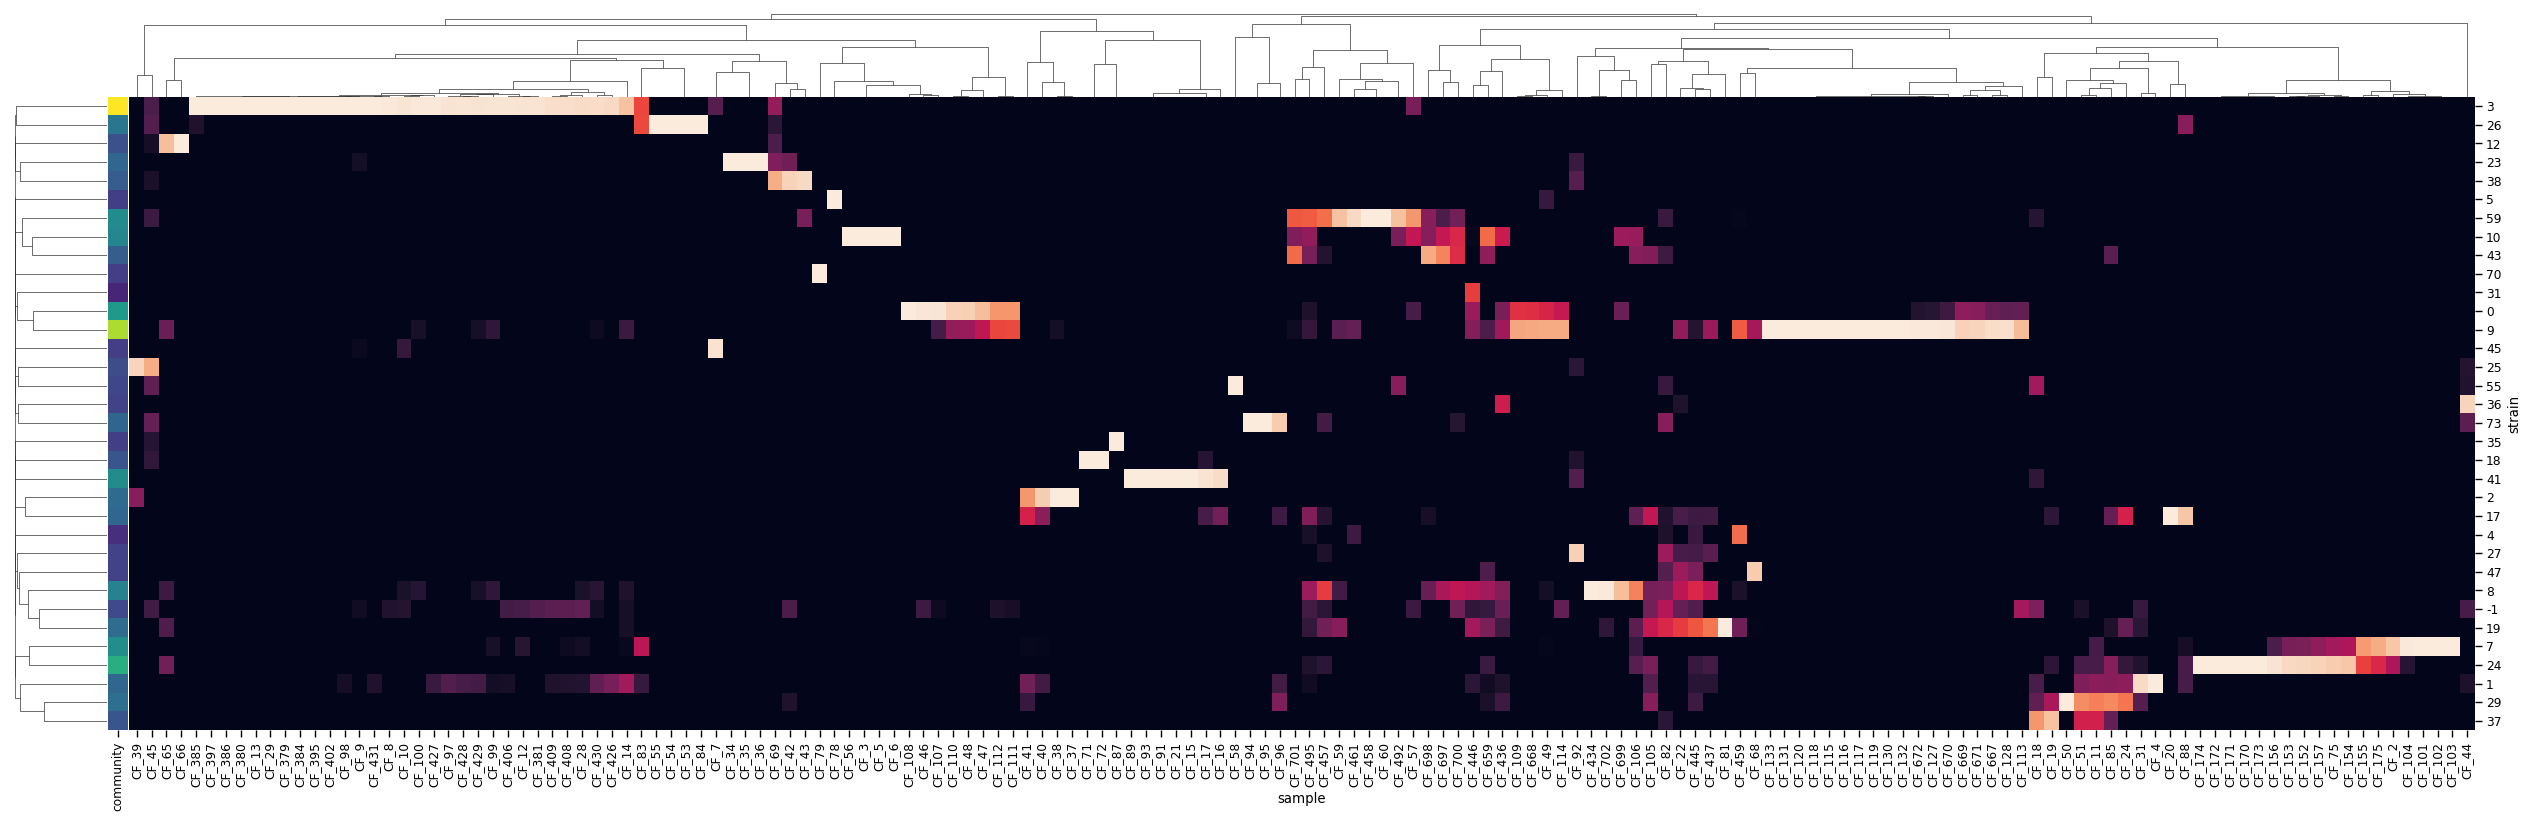

In [97]:
np.random.seed(0)

sample_linkage = strain_fit.unifrac_linkage(optimal_ordering=True)
position_ss = strain_fit.random_sample(
    position=min(strain_fit.sizes["position"], 1000)
).position

sf.plot.plot_metagenotype(
    strain_fit.sel(position=position_ss), col_linkage_func=lambda w: sample_linkage
)
sf.plot.plot_community(strain_fit, col_linkage_func=lambda w: sample_linkage)

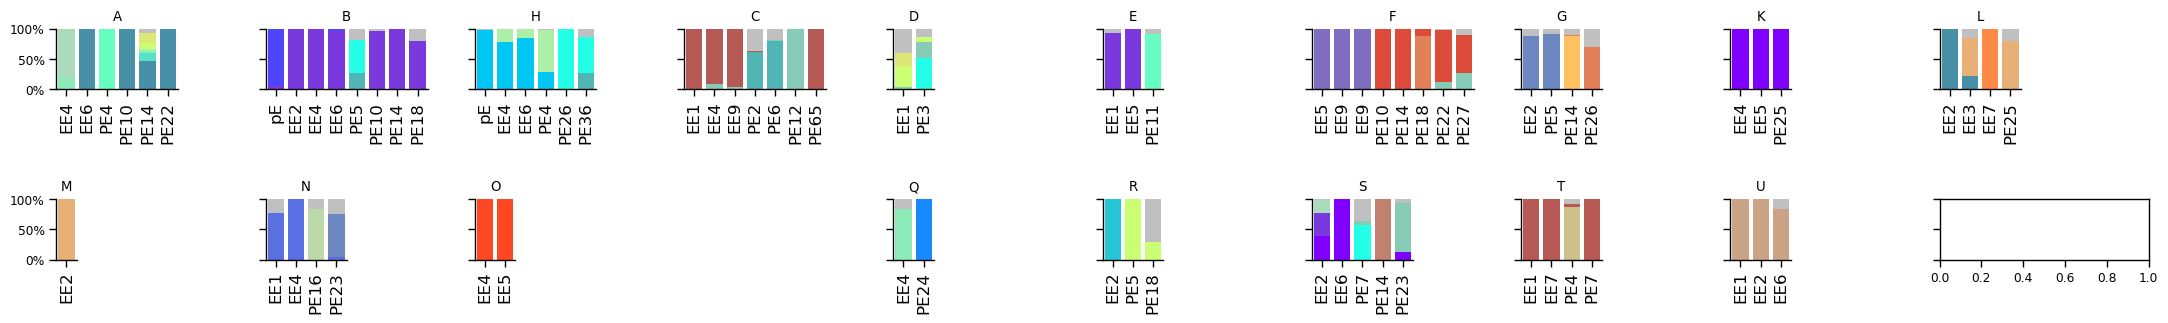

In [98]:
more_colors_strain_palette = lib.plot.construct_ordered_palette(
    strain_order,  # Linkage order, I believe
    cm="rainbow",
    extend={"-1": "silver"},
    desaturate_levels=[1.0, 0.7, 0.4],
)


sample.timepoint.map(rename_timepoints_for_ts)

fig, axs = plt.subplots(
    2,
    10,
    figsize=(10 * 2.7, 2 * 1.5),
    squeeze=False,
    sharey=True,
    gridspec_kw=dict(hspace=1.8, wspace=0),
)


for subject, ax in zip(subject_order, axs.flatten()):
    subject_comm_sample_list = list(
        set(idxwhere(sample.subject_id == subject)) & set(strain_fit.sample.values)
    )

    try:
        subject_comm = (
            strain_fit.sel(sample=subject_comm_sample_list)
            .drop_low_abundance_strains(0.2, agg_strain_coord="-1")
            .community.to_pandas()
        )
    except ValueError:
        subject_comm = pd.DataFrame([], columns=["-1"])

    sample_list = sample.sort_values("collection_date_relative_een_end")[
        lambda x: (x.subject_id == subject)
        & (x.sample_type == "human")
        & (x.index.isin(subject_comm.index))
    ].index

    if len(sample_list) == 0:
        lib.plot.hide_axes_and_spines(ax=ax)
        continue

    d = (
        sample.reindex(sample_list)
        # .dropna(subset=["collection_date_relative_een_end"])
        # .sort_values("collection_date_relative_een_end")
        .assign(
            t=lambda x: range(len(x)),
        )
    ).join(subject_comm)
    # d.loc[d.index[:num_offset_samples], 't'] -= 0.7  # Offset width

    plot_stacked_barplot(
        data=d,
        x_var="t",
        order=[s for s in strain_order if s in subject_comm.columns],
        palette=more_colors_strain_palette,
        ax=ax,
        width=0.8,
        lw=0,
    )

    ax.set_title(subject)
    ax.set_xticklabels(
        d.timepoint.map(rename_timepoints_for_ts),
        fontsize=12,
    )
    ax.set_aspect(3, anchor="NW")
    ax.set_ylim(0, 1.0)
    lib.plot.rotate_xticklabels(rotation=90, ax=ax, ha="center")
    ax.set_yticks(np.linspace(0, 1.0, num=3))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, symbol="%"))
    ax.set_xlim(d.t.min() - 0.5, d.t.max() + 0.5)
    ax.spines[["right", "top"]].set_visible(False)
    # ax.legend(bbox_to_anchor=(1, 1), ncols=2)

fig.savefig(f"fig/een.strain_timeseries.{species}.pdf", bbox_inches="tight")

### 101346

In [99]:
species = "101346"


print(motu_taxonomy.loc[species])

d__                 d__Bacteria
p__             p__Bacteroidota
c__              c__Bacteroidia
o__            o__Bacteroidales
f__           f__Bacteroidaceae
g__              g__Bacteroides
s__    s__Bacteroides uniformis
Name: 101346, dtype: object


In [100]:
strain_fit = (
    sf.data.World.load(
        f"data/group/een/species/sp-{species}/r.proc.gtpro.sfacts-fit.world.nc"
    )
    .rename_coords(sample=lambda s: "CF_{}".format(int(s.split("_")[1])))
    .rename_coords(sample={"CF_11": "CF_15", "CF_15": "CF_11"})
    .drop_low_abundance_strains(0.2)
    .rename_coords(strain=str)
)
print(strain_fit.sizes)

# Genotype similarity ordered palette:
strain_linkage = strain_fit.genotype.linkage(optimal_ordering=True)
strain_order = list(
    linkage_order(
        strain_linkage,
        strain_fit.strain.values,
    )
)
strain_order.remove("-1")  # Drop "other" strain.
strain_order.append("-1")  # Add to end of list
strain_palette = lib.plot.construct_ordered_palette(
    strain_order,
    cm="rainbow",
    extend={"-1": "silver"},
)

sf.evaluation.metagenotype_error2(strain_fit, discretized=True)[0]

Frozen({'strain': 20, 'position': 1542, 'sample': 119, 'allele': 2})


0.0011195276165381074

/include/StrainFacts/sfacts/plot.py:163: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(row_col_annotation_cmap)
/include/StrainFacts/sfacts/plot.py:175: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(row_col_annotation_cmap)


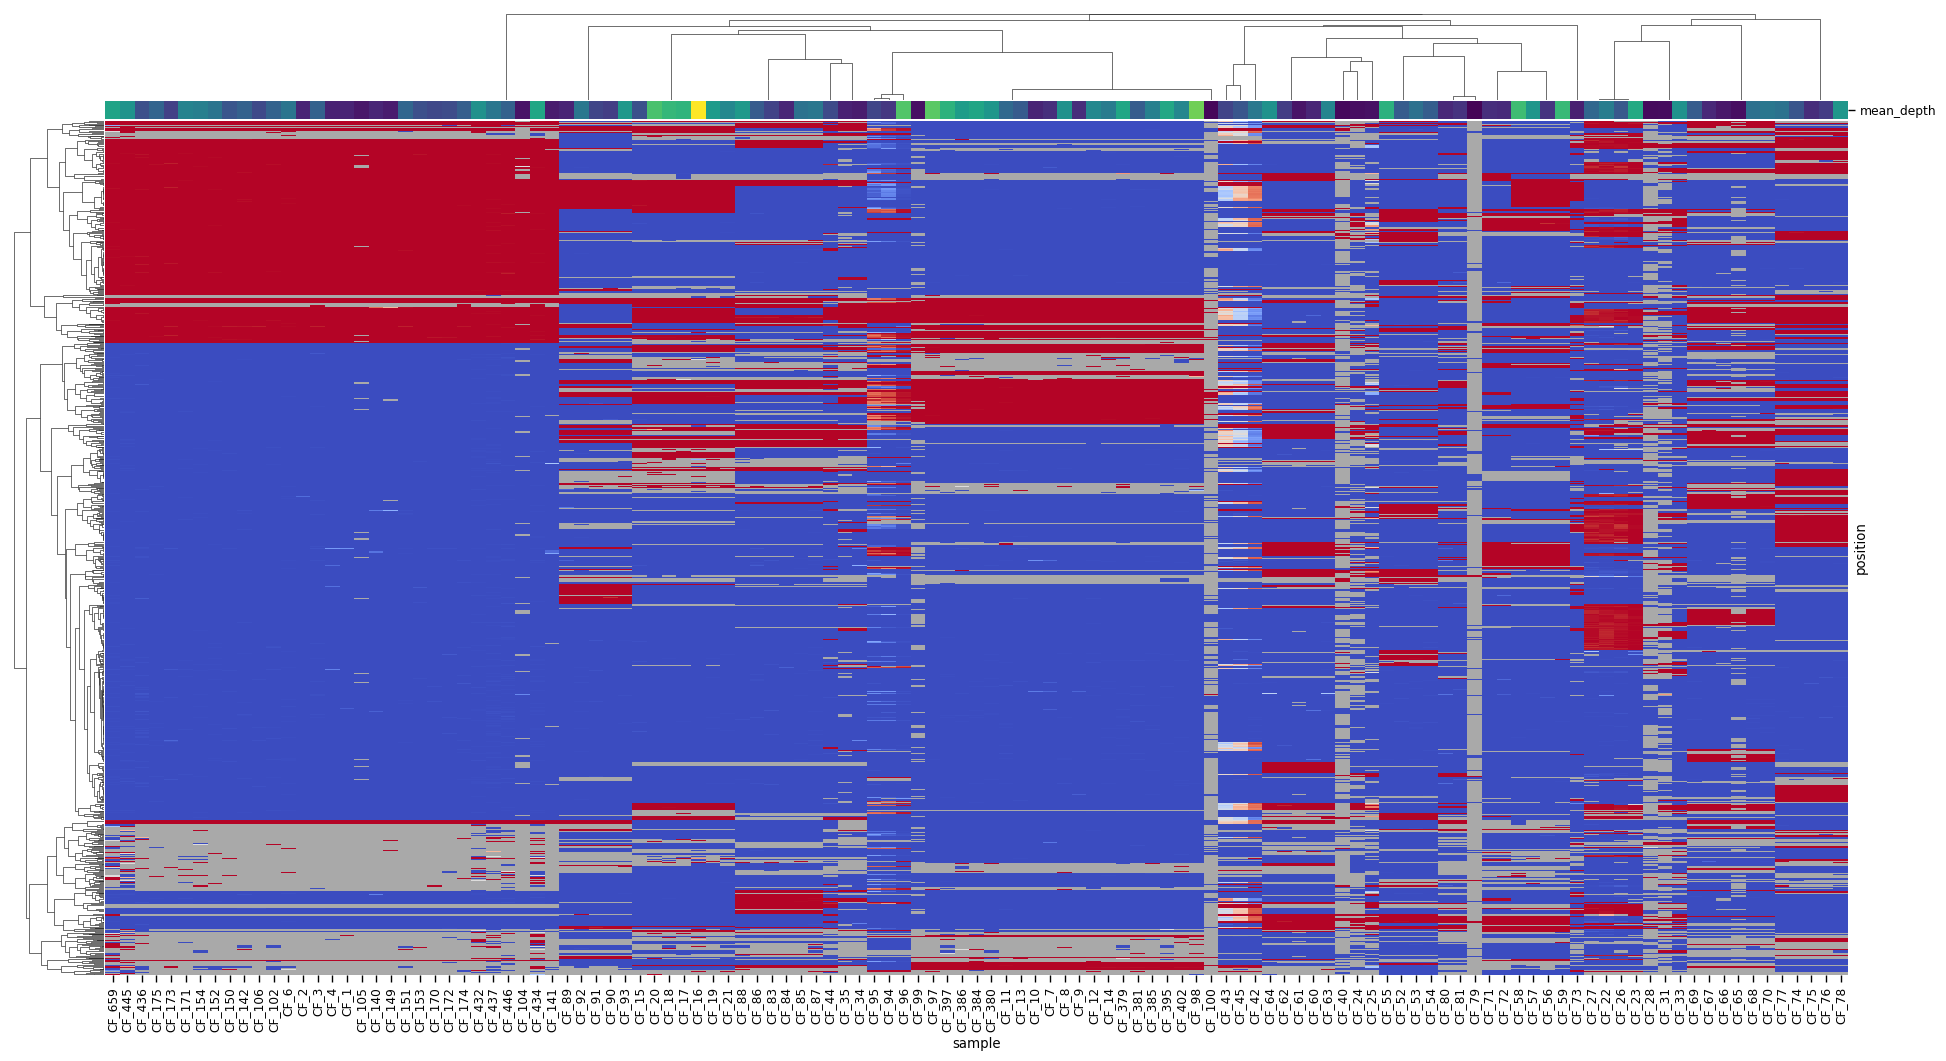

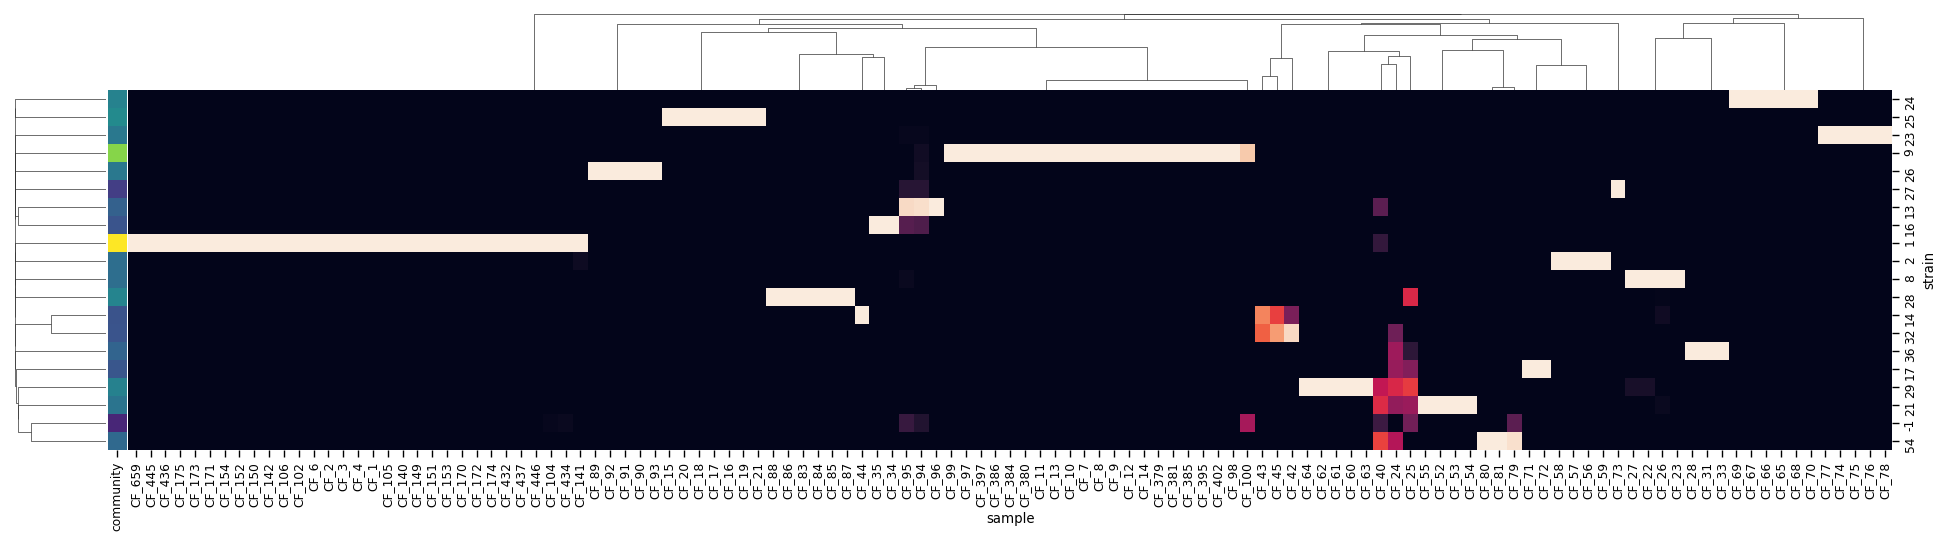

In [101]:
np.random.seed(0)

sample_linkage = strain_fit.unifrac_linkage(optimal_ordering=True)
position_ss = strain_fit.random_sample(
    position=min(strain_fit.sizes["position"], 1000)
).position

sf.plot.plot_metagenotype(
    strain_fit.sel(position=position_ss), col_linkage_func=lambda w: sample_linkage
)
sf.plot.plot_community(strain_fit, col_linkage_func=lambda w: sample_linkage)

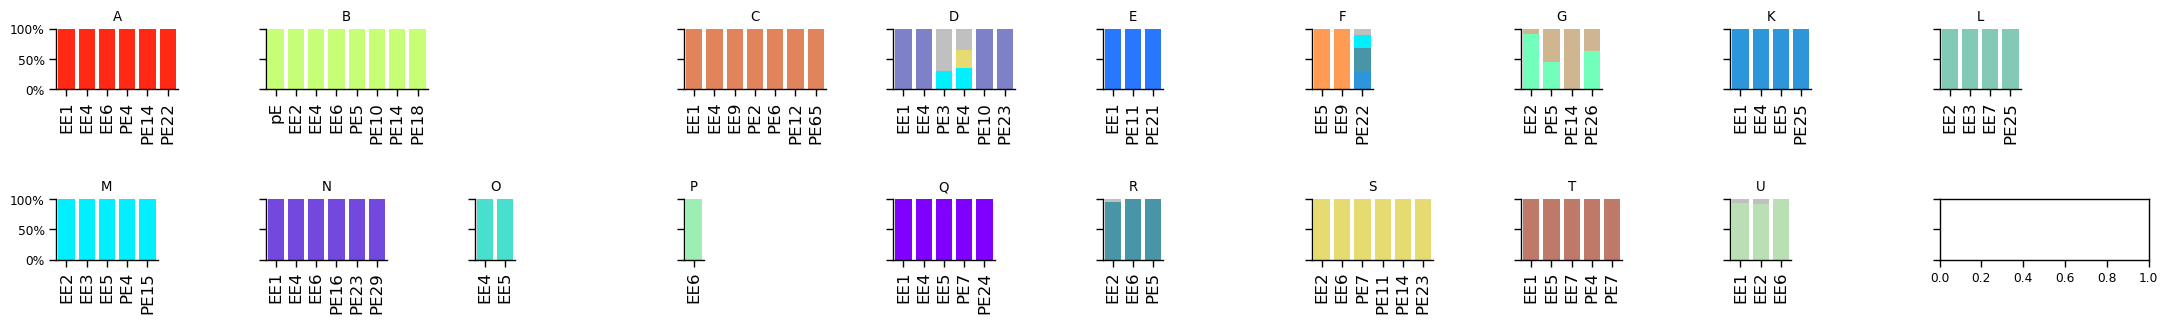

In [102]:
more_colors_strain_palette = lib.plot.construct_ordered_palette(
    strain_order,  # Linkage order, I believe
    cm="rainbow",
    extend={"-1": "silver"},
    desaturate_levels=[1.0, 0.7, 0.4],
)


sample.timepoint.map(rename_timepoints_for_ts)

fig, axs = plt.subplots(
    2,
    10,
    figsize=(10 * 2.7, 2 * 1.5),
    squeeze=False,
    sharey=True,
    gridspec_kw=dict(hspace=1.8, wspace=0),
)


for subject, ax in zip(subject_order, axs.flatten()):
    subject_comm_sample_list = list(
        set(idxwhere(sample.subject_id == subject)) & set(strain_fit.sample.values)
    )

    try:
        subject_comm = (
            strain_fit.sel(sample=subject_comm_sample_list)
            .drop_low_abundance_strains(0.2, agg_strain_coord="-1")
            .community.to_pandas()
        )
    except ValueError:
        subject_comm = pd.DataFrame([], columns=["-1"])

    sample_list = sample.sort_values("collection_date_relative_een_end")[
        lambda x: (x.subject_id == subject)
        & (x.sample_type == "human")
        & (x.index.isin(subject_comm.index))
    ].index

    if len(sample_list) == 0:
        lib.plot.hide_axes_and_spines(ax=ax)
        continue

    d = (
        sample.reindex(sample_list)
        # .dropna(subset=["collection_date_relative_een_end"])
        # .sort_values("collection_date_relative_een_end")
        .assign(
            t=lambda x: range(len(x)),
        )
    ).join(subject_comm)
    # d.loc[d.index[:num_offset_samples], 't'] -= 0.7  # Offset width

    plot_stacked_barplot(
        data=d,
        x_var="t",
        order=[s for s in strain_order if s in subject_comm.columns],
        palette=more_colors_strain_palette,
        ax=ax,
        width=0.8,
        lw=0,
    )

    ax.set_title(subject)
    ax.set_xticklabels(
        d.timepoint.map(rename_timepoints_for_ts),
        fontsize=12,
    )
    ax.set_aspect(3, anchor="NW")
    ax.set_ylim(0, 1.0)
    lib.plot.rotate_xticklabels(rotation=90, ax=ax, ha="center")
    ax.set_yticks(np.linspace(0, 1.0, num=3))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, symbol="%"))
    ax.set_xlim(d.t.min() - 0.5, d.t.max() + 0.5)
    ax.spines[["right", "top"]].set_visible(False)
    # ax.legend(bbox_to_anchor=(1, 1), ncols=2)

fig.savefig(f"fig/een.strain_timeseries.{species}.pdf", bbox_inches="tight")

## Species Summary and Scoring

SignificanceResult(statistic=0.0836509098368681, pvalue=0.2563140432493271)


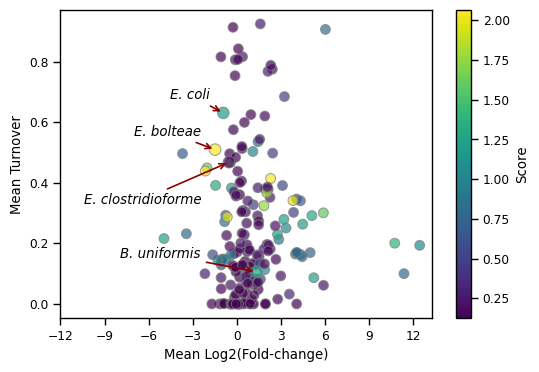

In [81]:
d0 = (
    motu_enrichment_results.join(per_species_obs_coefs)
    .join(species_turnover_analysis_details)
    .assign(
        uhgg_taxonomy=motu_lineage_string,
        zotu_match=reciprocal_hits_filtered.reset_index().groupby('species_id').zotu.apply(', '.join),
        subject_prevalence=(motu_prevalence_by_subject > 0).mean(),
        mean_rabund=lambda x: (x.mean_EEN + x.mean_PostEEN) / 2,
        indicator_score=lambda x: np.abs(x.log2_ratio)
        * x.num_pairs
        * x.mean_rabund
        * x.overall_mean_diss,
    )
    .rename(
        columns=dict(
            log2_ratio="species_log2_fold_change",
            mean_rabund="species_overall_mean_relative_abundance",
            num_pairs="num_intrasubject_sample_pairs",
            overall_mean_diss="mean_pairwise_braycurtis_dissimilarity",
            zotu_match="zotu_match",
        )
    )
)

# # Save statistics
# (
#     d0.sort_values("indicator_score", ascending=False)[
#         lambda x: x.indicator_score > 0.1
#     ][
#         [
#             "indicator_score",
#             "species_log2_fold_change",
#             "species_overall_mean_relative_abundance",
#             "mean_pairwise_braycurtis_dissimilarity",
#             "num_intrasubject_sample_pairs",
#             "uhgg_taxonomy",
#             "zotu_match",
#         ]
#     ]
#     .round(3)
#     .to_csv("fig/een_turnover_stats.tsv", sep="\t")
# )

d1 = d0[
    lambda x: (x.num_intrasubject_sample_pairs > 20)
    & (~x.species_overall_mean_relative_abundance.isna())
].assign(zorder=0)


focal_species_style_map = {
    "101493": ("E. bolteae", (-10, 10)),
    "101386": ("E. clostridioforme", (-20, -30)),
    "102506": ("E. coli", (-10, 10)),
    "101346": ("B. uniformis", (-40, 10)),
}

d1.loc[focal_species_style_map.keys(), "zorder"] = 1

fig, ax = plt.subplots(figsize=(6, 4))
plt.scatter(
    "species_log2_fold_change",
    "mean_pairwise_braycurtis_dissimilarity",
    data=d1[d1.zorder == 0],
    c="indicator_score",
    zorder=0,
    norm=mpl.colors.SymLogNorm(linthresh=0.1, linscale=0.5),
    s=50,
    edgecolor="grey",
    alpha=0.7,
)

plt.scatter(
    "species_log2_fold_change",
    "mean_pairwise_braycurtis_dissimilarity",
    data=d1[d1.zorder == 1],
    c="indicator_score",
    zorder=1,
    # norm=mpl.colors.SymLogNorm(linthresh=0.1, linscale=0.5),
    s=70,
    edgecolor="grey",
    alpha=0.7,
)
# plt.ylim(-0.5, 1.5)
cbar = plt.colorbar(label="Score", alpha=1.0)
cbar.solids.set(alpha=1)

for _species, (_name, (textx, texty)) in focal_species_style_map.items():
    # plt.scatter(
    #     "species_log2_fold_change",
    #     "mean_pairwise_braycurtis_dissimilarity",
    #     data=d1.loc[[_species]],
    #     edgecolor=_color,
    #     facecolor="none",
    #     s=200,
    # )
    plt.annotate(
        _name,
        xy=d1.loc[
            _species,
            ["species_log2_fold_change", "mean_pairwise_braycurtis_dissimilarity"],
        ].values,
        xytext=(textx, texty),
        textcoords="offset points",
        # rotation=rotation,
        fontstyle='italic',
        arrowprops=dict(arrowstyle="->", color='darkred', linewidth=1.2),
        ha='right',
        
    )

plt.xlabel("Mean Log2(Fold-change)")
plt.ylabel("Mean Turnover")
# plt.yscale('symlog', linthresh=1e-2)
# plt.xlim(-13, 6)
plt.xticks([-12, -9, -6, -3, 0, 3, 6, 9, 12])
plt.savefig("fig/een_turnover_stats.pdf", bbox_inches="tight")


print(
    sp.stats.spearmanr(
        d1.species_log2_fold_change, d1.mean_pairwise_braycurtis_dissimilarity
    )
)

#### Supplementary Table 4

In [82]:
species_transition_test_pvalue

species_id
100003    0.166
100013    0.458
100016    0.184
100022    0.004
100028    0.908
          ...  
104341    0.758
104468    0.894
104501    0.406
104526    0.490
104639    0.308
Length: 285, dtype: float64

In [83]:
d0 = (
    motu_enrichment_results.join(per_species_obs_coefs)
    .join(species_turnover_analysis_details)
    .assign(
        zotu_match=reciprocal_hits_filtered.reset_index().groupby('species_id').zotu.apply(', '.join),
        subject_prevalence=(motu_prevalence_by_subject > 0).mean(),
        mean_rabund=lambda x: (x.mean_EEN + x.mean_PostEEN) / 2,
        indicator_score=lambda x: np.abs(x.log2_ratio)
        * x.mean_rabund
        * x.num_pairs
        * x.overall_mean_diss,
        transition_turnover_effect=transition_stats_obs.transition_vs_mean,
        transition_turnover_pvalue=species_transition_test_pvalue,
    )
    .rename(
        columns=dict(
            log2_ratio="species_log2_fold_change",
            pvalue="species_pvalue",
            mean_rabund="species_overall_mean_relative_abundance",
            num_pairs="num_intrasubject_sample_pairs",
            overall_mean_diss="mean_pairwise_braycurtis_dissimilarity",
            zotu_match="zotu_match",

        )
    )
)

d1 = (
    d0.dropna(subset=['indicator_score']).sort_values("indicator_score", ascending=False)
    .assign(
        indicator_score=lambda x: x.indicator_score.round(3),
        species_log2_fold_change=lambda x: x.species_log2_fold_change.round(1),
        species_pvalue=lambda x: x.species_pvalue.round(4),
        species_overall_mean_relative_abundance=lambda x: x.species_overall_mean_relative_abundance.round(4),
        num_intrasubject_sample_pairs=lambda x: x.num_intrasubject_sample_pairs.astype(int),
        mean_pairwise_braycurtis_dissimilarity=lambda x: x.mean_pairwise_braycurtis_dissimilarity.round(2),
        transition_turnover_effect=lambda x: x.transition_turnover_effect.round(2),
        transition_turnover_pvalue=lambda x: x.transition_turnover_pvalue.round(4),
        # zotu_match=lambda x: x.zotu_match.fillna(""),
        uhgg_taxonomy=motu_taxonomy.s__,
        uhgg_url=lambda x: "https://www.ebi.ac.uk/metagenomics/genomes/MGYG0000" + x.index.to_series().str[1:],
        ezbc_id="",
        network_association="",
    )
    [
        [
            "indicator_score",
            "species_log2_fold_change",
            "species_pvalue",
            "species_overall_mean_relative_abundance",
            "num_intrasubject_sample_pairs",
            "mean_pairwise_braycurtis_dissimilarity",
            "transition_turnover_effect",
            "transition_turnover_pvalue",
            "zotu_match",
            "uhgg_taxonomy",
            "uhgg_url",
            "ezbc_id",
            "network_association",
        ]
    ]
)

d1[lambda x: x.indicator_score > 0.1].to_csv("fig/een_supplementary_table_s4.tsv", sep="\t")
d1[lambda x: x.indicator_score > 0.1]

,indicator_score,species_log2_fold_change,species_pvalue,species_overall_mean_relative_abundance,num_intrasubject_sample_pairs,mean_pairwise_braycurtis_dissimilarity,transition_turnover_effect,transition_turnover_pvalue,zotu_match,uhgg_taxonomy,uhgg_url,ezbc_id,network_association
motu_id,,,,,,,,,,,,,
103682,3.128,-2.2,0.0038,0.0188,176,0.44,-0.08,0.176,Zotu78,s__Ruthenibacterium lactatiformans,https://www.ebi.ac.uk/metagenomics/genomes/MGY...,,
101338,3.095,2.3,0.7820,0.0215,151,0.41,-0.07,0.068,Zotu13,s__Blautia_A wexlerae,https://www.ebi.ac.uk/metagenomics/genomes/MGY...,,
102478,2.746,-0.7,0.7764,0.0955,154,0.29,-0.04,0.400,"Zotu1, Zotu11",s__Bacteroides_B dorei,https://www.ebi.ac.uk/metagenomics/genomes/MGY...,,
102528,2.580,3.8,0.1046,0.0158,125,0.34,0.12,0.130,Zotu26,s__Anaerostipes hadrus,https://www.ebi.ac.uk/metagenomics/genomes/MGY...,,
101493,2.066,-1.5,0.0182,0.0143,191,0.51,-0.06,0.278,Zotu5,s__Clostridium_M bolteae,https://www.ebi.ac.uk/metagenomics/genomes/MGY...,,
102545,1.726,2.0,0.0962,0.0199,116,0.37,0.11,0.016,Zotu8,s__Faecalibacterium prausnitzii_G,https://www.ebi.ac.uk/metagenomics/genomes/MGY...,,
101378,1.514,1.8,0.1398,0.0175,145,0.32,0.15,0.008,"Zotu14, Zotu23",s__Bacteroides ovatus,https://www.ebi.ac.uk/metagenomics/genomes/MGY...,,
102506,1.200,-0.9,0.6322,0.0143,144,0.63,0.26,0.002,Zotu4,s__Escherichia coli_D,https://www.ebi.ac.uk/metagenomics/genomes/MGY...,,
101346,1.200,1.3,0.0739,0.0518,163,0.11,0.04,0.234,"Zotu48, Zotu6",s__Bacteroides uniformis,https://www.ebi.ac.uk/metagenomics/genomes/MGY...,,


In [84]:
d1[lambda x: x.indicator_score > 0.1].zotu_match.isna().value_counts()

zotu_match
False    37
True      9
Name: count, dtype: int64

In [85]:
d1.loc[['101493', '101386', '102506', '101346']]

,indicator_score,species_log2_fold_change,species_pvalue,species_overall_mean_relative_abundance,num_intrasubject_sample_pairs,mean_pairwise_braycurtis_dissimilarity,transition_turnover_effect,transition_turnover_pvalue,zotu_match,uhgg_taxonomy,uhgg_url,ezbc_id,network_association
motu_id,,,,,,,,,,,,,
101493,2.066,-1.5,0.0182,0.0143,191,0.51,-0.06,0.278,Zotu5,s__Clostridium_M bolteae,https://www.ebi.ac.uk/metagenomics/genomes/MGY...,,
101386,0.126,-0.5,0.8999,0.0039,128,0.47,0.19,0.004,Zotu5,s__Clostridium_M clostridioforme,https://www.ebi.ac.uk/metagenomics/genomes/MGY...,,
102506,1.200,-0.9,0.6322,0.0143,144,0.63,0.26,0.002,Zotu4,s__Escherichia coli_D,https://www.ebi.ac.uk/metagenomics/genomes/MGY...,,
101346,1.200,1.3,0.0739,0.0518,163,0.11,0.04,0.234,"Zotu48, Zotu6",s__Bacteroides uniformis,https://www.ebi.ac.uk/metagenomics/genomes/MGY...,,


In [86]:
d1[lambda x: (x.indicator_score > 0.1) & (x.transition_turnover_pvalue < 0.05) & (x.transition_turnover_effect > 0)]

,indicator_score,species_log2_fold_change,species_pvalue,species_overall_mean_relative_abundance,num_intrasubject_sample_pairs,mean_pairwise_braycurtis_dissimilarity,transition_turnover_effect,transition_turnover_pvalue,zotu_match,uhgg_taxonomy,uhgg_url,ezbc_id,network_association
motu_id,,,,,,,,,,,,,
102545,1.726,2.0,0.0962,0.0199,116,0.37,0.11,0.016,Zotu8,s__Faecalibacterium prausnitzii_G,https://www.ebi.ac.uk/metagenomics/genomes/MGY...,,
101378,1.514,1.8,0.1398,0.0175,145,0.32,0.15,0.008,"Zotu14, Zotu23",s__Bacteroides ovatus,https://www.ebi.ac.uk/metagenomics/genomes/MGY...,,
102506,1.200,-0.9,0.6322,0.0143,144,0.63,0.26,0.002,Zotu4,s__Escherichia coli_D,https://www.ebi.ac.uk/metagenomics/genomes/MGY...,,
101396,1.051,-2.0,0.0027,0.0064,180,0.45,0.12,0.026,Zotu34,s__Absiella innocuum,https://www.ebi.ac.uk/metagenomics/genomes/MGY...,,
100150,0.416,-5.0,0.0096,0.0042,92,0.22,0.15,0.004,Zotu160,s__Hungatella hathewayi,https://www.ebi.ac.uk/metagenomics/genomes/MGY...,,
100076,0.281,12.4,0.0029,0.0045,26,0.19,0.02,0.014,Zotu35,s__Roseburia intestinalis,https://www.ebi.ac.uk/metagenomics/genomes/MGY...,,
100113,0.166,1.4,0.5282,0.0014,156,0.54,0.10,0.014,NaN,s__Streptococcus salivarius,https://www.ebi.ac.uk/metagenomics/genomes/MGY...,,
102445,0.135,4.1,0.0995,0.0037,53,0.17,0.29,0.004,NaN,s__Clostridium_Q sp003024715,https://www.ebi.ac.uk/metagenomics/genomes/MGY...,,
101386,0.126,-0.5,0.8999,0.0039,128,0.47,0.19,0.004,Zotu5,s__Clostridium_M clostridioforme,https://www.ebi.ac.uk/metagenomics/genomes/MGY...,,
